# RNA-seq Analysis of patients with mutations in the autoinhibitory helix of PPP3CA

## Background

Here we will determine whether patients with misssense mutations in the autoinhibitory helix of PPP3CA (catalytic subunit of the calcineurin phosphatase) have altered transcriptional signatures compared to patients with missense mutations in PPP3CA but outside its autoinhibitory helix. Protein autoinhibition is a prevalent mechanism for the control of protein function and mutations that alter autoinhibition are common in cancer driver genes. PPP3CA is not yet categorized as a cancer driver, but mutations within its autoinhibitory helix could be cancer promoting. This is due to the regulatory role that calcinuerin exerts on the NFAT transcription factors, which are known to be misregulated in several cancer types.

**Summary of the pipeline**

1. Download the STAR Counts data from the NCI-GDC database
2. Remove samples with small library sizes
3. Filter out lowly expressed genes
4. Perform some exploratory data analyses using PCA and heatmaps
5. Estimate sources of unwanted variation using `svaseq`
6. Perform the differential gene expression analysis using `DESeq2`

In [1]:
gene = 'PPP3CA'

In [2]:
suppressPackageStartupMessages({
    library(GenomicDataCommons)
    library(DESeq2)
    library(edgeR)
    library(pheatmap)
    library(RColorBrewer)
    library(ggplot2)
    library(EDASeq)
    library(ggforce)
    library(EnhancedVolcano)
    library(dplyr)
    library(tidyverse)
    library(sva)
})

The functions below where taken from the `GenomicDataCommons` package and they were modified slightly to allow the download of STAR Count files from the NCI-GDC using their File ID

In [3]:
#' Import multiple files of STAR - Counts format
#' 
#' @importFrom dplyr bind_cols
#' @importFrom readr read_tsv
#' 
# After the new release of GDC (March 29, 2022) the format of the RNA-seq files changed from 
# HTSeq-counts to STAR-Counts 

.star_counts_importer = function(fnames) {
    if(is.list(fnames))
        fnames = unlist(fnames)
    first = readr::read_tsv(fnames[1], col_names = FALSE, skip=6)
    gene_ids = first[[1]]
    gene_names = first[[2]]
    gene_types = first[[3]]
    res = dplyr::bind_cols(lapply(fnames, function(fname){
        readr::read_tsv(fname, col_names = FALSE, skip=6)[,4]
    }))
    colnames(res) = names(fnames)
    res = data.frame(gene_ids, gene_names, gene_types, res)
    return(res)
}

#' @describeIn gdc_rnaseq Show possible RNA-seq workflow types
#' 
#' 
#' @examples
#' available_rnaseq_workflows()
#' 
#' @export
available_rnaseq_workflows = function() {
    possible_workflows = GenomicDataCommons::files() %>% 
        GenomicDataCommons::filter( ~ data_type=="Gene Expression Quantification" & 
                                        data_type=="Gene Expression Quantification") %>% 
        facet("analysis.workflow_type") %>% 
        aggregations() 
    return(possible_workflows[['key']])
}

gdc_rnaseq_2 = function(file_list, workflow_type) {
    
    # Just double-check that the specified workflow is available
    possible_workflows = GenomicDataCommons::files() %>% 
        GenomicDataCommons::filter( ~ data_type=="Gene Expression Quantification" & 
                    data_type=="Gene Expression Quantification") %>% 
        facet("analysis.workflow_type") %>% 
        aggregations()
    possible_workflows = possible_workflows[['analysis.workflow_type']][['key']]
    if(!(workflow_type %in% possible_workflows)) 
        stop(sprintf("Workflow type must be one of: %s",paste(possible_workflows,"\n")))
    
    # fetch the actual data
    # Will use cached data if available
    fnames = gdcdata(file_list)
    
    # This retrieves basic case info for each file.
    # Assumes that file_id is 1-1 with case_id
    file_and_case_info = GenomicDataCommons::files() %>% 
        GenomicDataCommons::expand('cases') %>%
        GenomicDataCommons::filter(~ file_id %in% names(fnames)) %>% 
        results_all()
    case_df = dplyr::bind_rows(file_and_case_info$cases, .id='file_id') %>%
        dplyr::select(case_id,file_id)
    
    # Expand the coldata with clinical data
    clin_data_list = gdc_clinical(case_df[['case_id']])
    # Some clinical data.frames may not be 1-1 with the case_ids.
    # This just filters out those data.frames that do not have
    # the same number of rows.
    number_of_cases = nrow(clin_data_list$demographic)
    
    clin_data_list = clin_data_list[sapply(clin_data_list,nrow) == number_of_cases]
    
    # This is just to rename columns. A column like "submitter_id"
    # is included in several of the clinical data.frames, but the 
    # information is different in each. This code disambiguates by
    # attaching a suffix.
    all_colnames = unlist(sapply(clin_data_list,colnames))
    duped_colnames = unique(all_colnames[duplicated(all_colnames)])
    duped_colnames = duped_colnames[! duped_colnames=='case_id']
    clin_data_list_renamed = lapply(names(clin_data_list), function(n) {
        df = clin_data_list[[n]]
        df_colnames = colnames(df)
        idx = df_colnames %in% duped_colnames
        df_colnames[idx] = paste(df_colnames[idx],n,sep='.')
        colnames(df) = df_colnames
        return(df)
    })
    names(clin_data_list_renamed) = names(clin_data_list)
    for(i in names(clin_data_list_renamed)) {
        case_df = case_df %>% dplyr::left_join(clin_data_list_renamed[[i]], 
                                               by = c('case_id' = 'case_id'),
                                               suffix = c(paste0('.',i),'.case'))
    }
    coldata = case_df
    
    # probably not needed, but reorder based on file_ids from fname
    # vector to match up columns in the assays matrix
    coldata = coldata[match(names(fnames), coldata$file_id),]
#     mat = .htseq_importer(fnames)
    mat = .star_counts_importer(fnames)
    
    if (workflow_type == 'HTSeq - Counts'){
        qc_idx = grepl("^__",mat[[1]])
        mat_qc = data.frame(t(mat[qc_idx, -1]))
        colnames(mat_qc) = paste0('qc',mat[qc_idx,1])
        coldata = dplyr::bind_cols(coldata,mat_qc)
        mat = mat[!qc_idx, ]
    }

    rowdata = S4Vectors::DataFrame(gene_id = mat[[1]], gene_name = mat[[2]], gene_type = mat[[3]])
    se = SummarizedExperiment::SummarizedExperiment(list(exprs=as.matrix(mat[,-c(1, 2, 3)])), 
                                                    rowData = rowdata, colData = coldata)
    rownames(se) = rowdata[['gene_id']]
    colnames(se) = names(fnames)
    return(se)
}

Load the sample sheet, which contains the File IDs of patients with missense mutations inside and outside the autoinhibitory helix of PPP3CA

In [4]:
sample_sheet = read.table('./data/sample_sheet.tsv', sep='\t', header=TRUE)

In [5]:
dat = sample_sheet[grep(gene, sample_sheet$Mutation.Status), ]

In [6]:
dat[grep(paste0(gene, ".outside.IAS"), dat$Mutation.Status), ]$Mutation.Status = paste0(gene, ".outside.IAS")
dat[grep(paste0(gene, ".inside.IAS"), dat$Mutation.Status), ]$Mutation.Status = paste0(gene, ".inside.IAS")

In [7]:
dat$Project.ID = gsub('-', '_', dat$Project.ID) # to prevent DESeq2 from complaining that we have '-' in a variable name

In [8]:
dat$Project.ID = factor(dat$Project.ID)

In [9]:
head(dat)

,File.ID,File.Name,Data.Category,Data.Type,Project.ID,Case.ID,Sample.ID,Sample.Type,entity_id,entity_submitter_id,plate_ID,is_ffpe,keep,Mutation.Status,n
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>
34,05c20e87-bd95-425e-a951-45356817270b,cf1a0bd8-1f5d-487a-90a3-efd038575b1d.rna_seq.augmented_star_gene_counts.tsv,Transcriptome Profiling,Gene Expression Quantification,TCGA_UCEC,TCGA-B5-A3FC,TCGA-B5-A3FC-01A,Primary Tumor,cfc3065f-652c-458b-926f-24092edb803f,TCGA-B5-A3FC-01A-11R-A22K-07,A22K,False,True,PPP3CA.outside.IAS,10
42,0700c686-4a51-499f-9f0e-7fa21c402af4,a6619a5f-fd99-49f8-8e41-2d28b8bd54db.rna_seq.augmented_star_gene_counts.tsv,Transcriptome Profiling,Gene Expression Quantification,TCGA_UCEC,TCGA-D1-A2G0,TCGA-D1-A2G0-01A,Primary Tumor,ca1b7ca7-5c8b-442d-ab3d-29bd16de1229,TCGA-D1-A2G0-01A-11R-A32Y-07,A32Y,False,True,PPP3CA.outside.IAS,1
85,0ed6cbf4-3db1-48b0-b921-8b9397f564b3,b4f5cc56-d533-424d-8fa9-fb56bc38f6f9.rna_seq.augmented_star_gene_counts.tsv,Transcriptome Profiling,Gene Expression Quantification,TCGA_CESC,TCGA-4J-AA1J,TCGA-4J-AA1J-01A,Primary Tumor,9d09804a-304a-4f05-af84-af513c97f3ed,TCGA-4J-AA1J-01A-21R-A38B-07,A38B,False,True,PPP3CA.outside.IAS,1
113,16680c4f-fb49-4bd0-ba7c-58f132ca77f3,bf267abc-f008-4121-a0d6-039adfdbfb08.rna_seq.augmented_star_gene_counts.tsv,Transcriptome Profiling,Gene Expression Quantification,TCGA_HNSC,TCGA-CV-7568,TCGA-CV-7568-01A,Primary Tumor,900c7d97-3cfe-41de-bc9b-9205f039830f,TCGA-CV-7568-01A-11R-2232-07,2232,False,True,PPP3CA.outside.IAS,6
138,1bf5dfc9-9ac8-4e32-b362-b2b20fc39389,c4e36c8b-6250-4784-bc08-75b7d2549b94.rna_seq.augmented_star_gene_counts.tsv,Transcriptome Profiling,Gene Expression Quantification,TCGA_OV,TCGA-24-1843,TCGA-24-1843-01A,Primary Tumor,c50cf5af-3375-4748-9894-1f9521f746da,TCGA-24-1843-01A-01R-1567-13,1567,False,True,PPP3CA.outside.IAS,1
154,1e30f630-887a-4cff-a262-c0bac82c3af5,a8877d9c-7dfb-4544-bbb9-7ef4176f3429.rna_seq.augmented_star_gene_counts.tsv,Transcriptome Profiling,Gene Expression Quantification,TCGA_SKCM,TCGA-D3-A3C7,TCGA-D3-A3C7-06A,Metastatic,75838292-c5fe-45f1-8fa5-94403cfc3bdf,TCGA-D3-A3C7-06A-11R-A18U-07,A18U,False,True,PPP3CA.outside.IAS,1


In [10]:
dim(dat)

[1] 76 15

In [11]:
dat_files = as.character(dat[['File.ID']])

In [12]:
dat_files[1]

[1] "05c20e87-bd95-425e-a951-45356817270b"

We use the `gdc_rnaseq_2` function defined above to download the data using the File IDs. The data is stored in a SummarizedExperiment

In [13]:
dat_se = suppressMessages(gdc_rnaseq_2(dat_files, 'STAR - Counts'))

In [14]:
dat_se

class: SummarizedExperiment 
dim: 60660 76 
metadata(0):
assays(1): exprs
rownames(60660): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000288674.1 ENSG00000288675.1
rowData names(3): gene_id gene_name gene_type
colnames(76): bfbbf133-5f61-4c42-9b82-a5d40be0928e
  fec22982-c32a-44bd-a1bb-0a377ed028e7 ...
  6e6328d3-251d-4b16-8990-2b43623a99c5
  84bb43ac-afd4-4f2b-aeee-bdbe0d2e8d88
colData names(134): case_id file_id ... index_date state.main

Remove metadata columns where all values are NAs

In [15]:
colData(dat_se) = colData(dat_se)[ , colSums(is.na(colData(dat_se))) < nrow(colData(dat_se))]

Add metadata from the sample sheet to the SummarizedExperiment and make sure the data in the columns is formatted appropriately and that all the information between the sample sheet and the SummarizedExperiment matches

In [16]:
dat = dat[match(row.names(colData(dat_se)), dat$File.ID),]

In [17]:
stopifnot(identical(row.names(colData(dat_se)), as.character(dat$File.ID)))

In [18]:
colData(dat_se)$Mutation.Status = droplevels(dat$Mutation.Status)

In [19]:
levels(colData(dat_se)$Mutation.Status)

[1] "PPP3CA.inside.IAS"  "PPP3CA.outside.IAS"

In [20]:
colData(dat_se)$Project.ID = droplevels(dat$Project.ID)

In [21]:
levels(colData(dat_se)$Project.ID)

[1] "CPTAC_3"   "TCGA_BLCA" "TCGA_BRCA" "TCGA_CESC" "TCGA_COAD" "TCGA_HNSC"
 [7] "TCGA_LGG"  "TCGA_LIHC" "TCGA_LUAD" "TCGA_LUSC" "TCGA_OV"   "TCGA_PAAD"
[13] "TCGA_PRAD" "TCGA_SKCM" "TCGA_STAD" "TCGA_UCEC"

In [22]:
colData(dat_se)$Sample.ID = droplevels(dat$Sample.ID)

In [23]:
stopifnot(identical(row.names(colData(dat_se)), colnames(assays(dat_se)$exprs)))

Visualize the RNA seq read count data, the column names are the File IDs and the rows are the genes

In [24]:
head(assays(dat_se)$exprs)

,bfbbf133-5f61-4c42-9b82-a5d40be0928e,fec22982-c32a-44bd-a1bb-0a377ed028e7,ae33e6d4-c8f4-433f-a67f-dc1ba4f7888f,2dfafc4f-de00-4ee1-95a0-9ee66518769b,816760da-fff8-4002-84b8-2c19415d0375,b7940add-4e68-48fb-8e01-d7ac73fa29fb,fb27874e-faf3-4d48-ad25-5664b1a7717d,0700c686-4a51-499f-9f0e-7fa21c402af4,36f15a0a-d691-403f-b283-f99c5610edd1,05c20e87-bd95-425e-a951-45356817270b,⋯,4320b770-69f3-4dd2-afea-8b7f7cdf44c2,b6a0d742-e7bc-4d67-8014-675e62f1ddd0,477b84d7-1ae0-42f9-91d5-3d63f89d10d2,d88c062b-3c19-46e9-92b8-b80f6c3eef56,648b0d02-f264-4d88-9997-baed8f000a60,f15dc2b8-c1e3-4e27-8245-c4706baa8517,b34c57e4-8afb-4b20-8634-dd38e8e7828d,40f2771e-e140-46ed-b472-91c0233e6528,6e6328d3-251d-4b16-8990-2b43623a99c5,84bb43ac-afd4-4f2b-aeee-bdbe0d2e8d88
ENSG00000000003.15,3700,1354,2937,1415,1475,1535,1800,3291,4567,2484,⋯,4702,6122,1802,6038,3424,5220,2708,2632,6692,2600
ENSG00000000005.6,13,8,31,17,3,11,12,1,33,9,⋯,0,0,0,0,1,1,0,1,0,1
ENSG00000000419.13,1196,1793,1828,933,1069,858,1023,2138,1169,1682,⋯,1571,2714,719,1470,1700,3130,2992,2029,3734,2299
ENSG00000000457.14,1487,1083,1939,662,1302,1441,1158,290,200,302,⋯,432,1042,541,1446,2170,445,900,1231,727,845
ENSG00000000460.17,628,1039,1056,298,1018,563,788,200,210,171,⋯,488,712,240,244,457,511,844,370,960,631
ENSG00000000938.13,136,240,295,844,610,213,300,181,653,348,⋯,738,840,102,1059,263,544,504,2702,1310,618


Convert the SummarizedExperiment to a DESeq data set, using the Project.ID as an adjustment variable (given that the data comes from different sequencing studies) and with the Mutation.Status (mutations inside or outside the autoinhibitory helix of PPP3CA) as the variable of interest.

In [25]:
dat_dds = DESeqDataSet(dat_se, design = ~ Project.ID + Mutation.Status)

renaming the first element in assays to 'counts'

converting counts to integer mode



## Remove samples with log2 library size 3 median absolute deviations below the median log2 library size

In [26]:
libsizes = data.frame('sample.ID' = colnames(assays(dat_dds)$counts), 
                      'libsize.in.millions' = colSums(assays(dat_dds)$counts)/10^6, 
                      'log2libsize' = log2(colSums(assays(dat_dds)$counts)))

In [27]:
head(libsizes)

,sample.ID,libsize.in.millions,log2libsize
,<fct>,<dbl>,<dbl>
bfbbf133-5f61-4c42-9b82-a5d40be0928e,bfbbf133-5f61-4c42-9b82-a5d40be0928e,39.27449,25.22709
fec22982-c32a-44bd-a1bb-0a377ed028e7,fec22982-c32a-44bd-a1bb-0a377ed028e7,35.93105,25.09873
ae33e6d4-c8f4-433f-a67f-dc1ba4f7888f,ae33e6d4-c8f4-433f-a67f-dc1ba4f7888f,52.09449,25.63463
2dfafc4f-de00-4ee1-95a0-9ee66518769b,2dfafc4f-de00-4ee1-95a0-9ee66518769b,35.63373,25.08674
816760da-fff8-4002-84b8-2c19415d0375,816760da-fff8-4002-84b8-2c19415d0375,32.37147,24.94822
b7940add-4e68-48fb-8e01-d7ac73fa29fb,b7940add-4e68-48fb-8e01-d7ac73fa29fb,34.95420,25.05896


In [28]:
mad(libsizes$log2libsize)*3

[1] 1.775323

In [29]:
lower_bound = median(libsizes$log2libsize) - mad(libsizes$log2libsize)*3
lower_bound

[1] 23.66848

In [30]:
libsizes$too_small = libsizes$log2libsize < lower_bound

In [31]:
libsizes[which(libsizes$too_small == TRUE),]

sample.ID,libsize.in.millions,log2libsize,too_small
<fct>,<dbl>,<dbl>,<lgl>


There are no samples with library sizes (log2) that are 3 median absolute deviations from the median library size

## Filter lowly expressed genes

According to this [paper](https://f1000research.com/articles/5-1438). Lowly expressed genes can be defined as those that have a CPM value less than `k` in `n` of the samples, where `k` is equal to 10/(minimum library size in millions) and `n` is the sample size of the smallest group. 

In [32]:
group1 = length(which(colData(dat_dds)$Mutation.Status == paste0(gene, '.inside.IAS')))
group1

[1] 12

In [33]:
group2 = length(which(colData(dat_dds)$Mutation.Status == paste0(gene, '.outside.IAS')))
group2

[1] 64

In [34]:
smallest = min(c(group1, group2))
smallest

[1] 12

In [35]:
assays(dat_dds)$cpm = cpm(assays(dat_dds)$counts, log = FALSE)

In [36]:
head(assays(dat_dds)$cpm)

,bfbbf133-5f61-4c42-9b82-a5d40be0928e,fec22982-c32a-44bd-a1bb-0a377ed028e7,ae33e6d4-c8f4-433f-a67f-dc1ba4f7888f,2dfafc4f-de00-4ee1-95a0-9ee66518769b,816760da-fff8-4002-84b8-2c19415d0375,b7940add-4e68-48fb-8e01-d7ac73fa29fb,fb27874e-faf3-4d48-ad25-5664b1a7717d,0700c686-4a51-499f-9f0e-7fa21c402af4,36f15a0a-d691-403f-b283-f99c5610edd1,05c20e87-bd95-425e-a951-45356817270b,⋯,4320b770-69f3-4dd2-afea-8b7f7cdf44c2,b6a0d742-e7bc-4d67-8014-675e62f1ddd0,477b84d7-1ae0-42f9-91d5-3d63f89d10d2,d88c062b-3c19-46e9-92b8-b80f6c3eef56,648b0d02-f264-4d88-9997-baed8f000a60,f15dc2b8-c1e3-4e27-8245-c4706baa8517,b34c57e4-8afb-4b20-8634-dd38e8e7828d,40f2771e-e140-46ed-b472-91c0233e6528,6e6328d3-251d-4b16-8990-2b43623a99c5,84bb43ac-afd4-4f2b-aeee-bdbe0d2e8d88
ENSG00000000003.15,94.2087417,37.6832840,56.3783222,39.7095662,45.56480667,43.9146083,50.2863823,85.89261215,116.5010780,66.6445252,⋯,116.59621,112.96332,37.275364,93.47616,58.78198071,87.74055367,38.983908,33.23727063,114.77061,49.92872674
ENSG00000000005.6,0.3310037,0.2226487,0.5950725,0.4770761,0.09267418,0.3146975,0.3352425,0.02609924,0.8418077,0.2414657,⋯,0.00000,0.00000,0.000000,0.00000,0.01716763,0.01680854,0.000000,0.01262814,0.00000,0.01920336
ENSG00000000419.13,30.4523392,49.9011287,35.0900827,26.1830567,33.02290056,24.5464064,28.5794273,55.80018377,29.8203986,45.1272509,⋯,38.95632,50.07880,14.872912,22.75753,29.18497874,52.61071513,43.072324,25.62250080,64.03967,44.14851645
ENSG00000000457.14,37.8617294,30.1410610,37.2208263,18.5779031,40.22059545,41.2253749,32.3509060,7.56878077,5.1018646,8.1025147,⋯,10.71237,19.22701,11.190884,22.38598,37.25376698,7.47979816,12.956247,15.54524322,12.46836,16.22683619
ENSG00000000460.17,15.9900243,28.9164934,20.2708574,8.3628627,31.44743945,16.1067912,22.0142607,5.21984881,5.3569578,4.5878477,⋯,12.10101,13.13784,4.964532,3.77744,7.84560899,8.58916148,12.150081,4.67241267,16.46440,12.11731791
ENSG00000000938.13,3.4628078,6.6794595,5.6627869,23.6854232,18.84375056,6.0936883,8.3810637,4.72396317,16.6575879,9.3366726,⋯,18.30030,15.49970,2.109926,16.39471,4.51508789,9.14384314,7.255498,34.12124060,22.46705,11.86767428


In [37]:
smallest_libsize = min(libsizes$libsize.in.millions)
smallest_libsize

[1] 19.37194

In [38]:
threshold = round(10/smallest_libsize, 1)
threshold

[1] 0.5

In [39]:
# Filter the genes that have a CPM of less than 0.5 in more than 12 samples
keep <- which(rowSums(assays(dat_dds)$cpm > threshold) > smallest)
length(keep)

[1] 20869

In [40]:
dat_dds = dat_dds[keep,]
nrow(dat_dds)

[1] 20869

## Exploratory Data Analysis

In [41]:
options(repr.plot.width = 15, repr.plot.height = 10) # set the size of all the plots below

### Distribution of counts

In [42]:
# function to convert dataframe from short to long format to plot with ggplot2
toLonger <- function(expressionMatrix) {
    expressionMatrix <- longExpressionMatrix <- expressionMatrix %>% 
    as.data.frame() %>%
    rownames_to_column("gene") %>%
    pivot_longer(cols = !gene, 
                 values_to = "Expression",
                 names_to = "sample") 
  return(expressionMatrix)
}

**Boxplot of gene expression values for each sample**

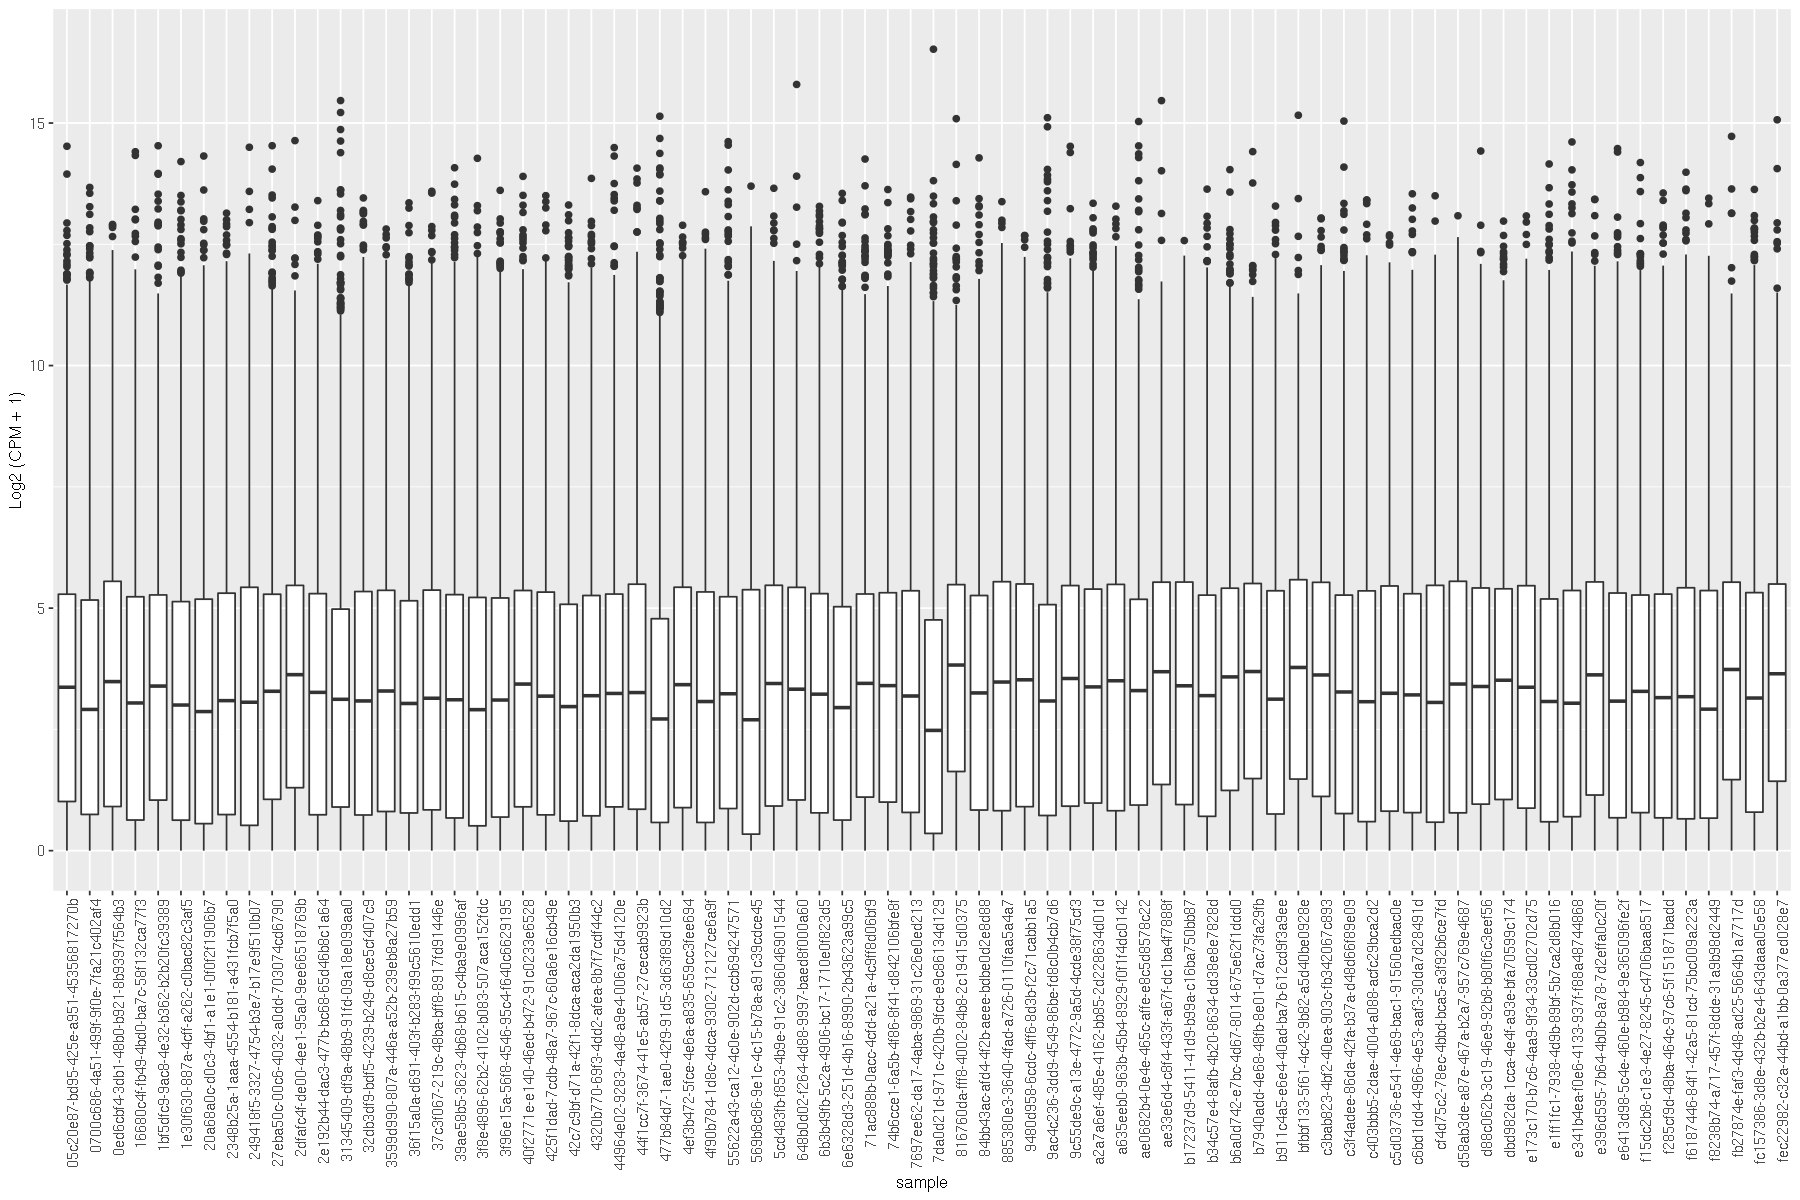

In [43]:
toLonger(log2(assays(dat_dds)$cpm + 1)) %>% 
  ggplot(aes(x = sample, y = Expression)) +
  geom_boxplot() + ylab('Log2 (CPM + 1)') +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

**Histograms of gene expression values for each sample**

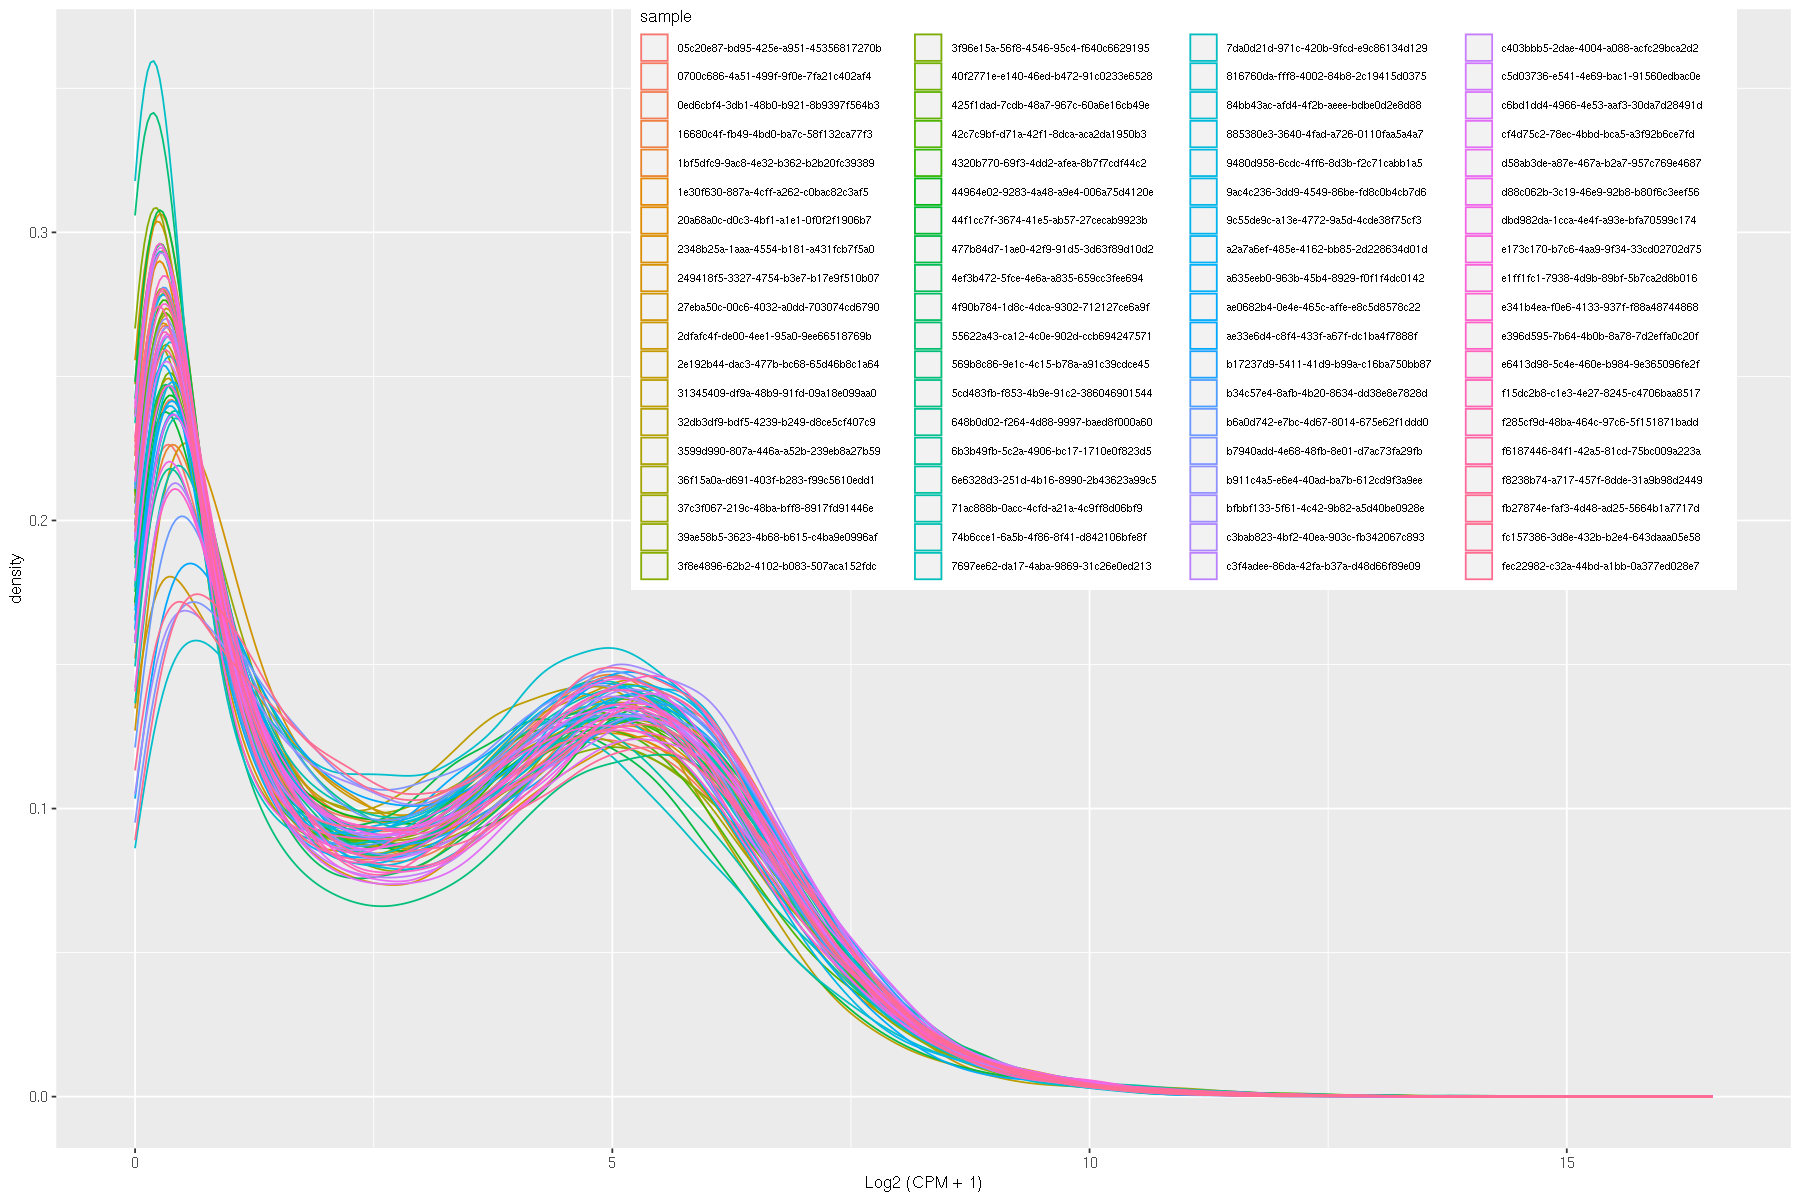

In [44]:
toLonger(log2(assays(dat_dds)$cpm + 1))  %>% 
  ggplot(aes(x = Expression, color = sample)) +
  geom_density() + xlab('Log2 (CPM + 1)') +
  theme(legend.position = c(0.65, 0.75), legend.text = element_text(size=7))

None of the samples appear to have a library size that is too small 

### Heatmap

- Here we use the variance stabilized transformation (vst) implemented in the `DESeq2` package to see how the samples cluster based on their gene expression profiles in a heatmap and a Principal Component Analysis (PCA) plot

In [45]:
dat_vsd <- vst(dat_dds, blind = FALSE)
head(assay(dat_vsd), 3)

,bfbbf133-5f61-4c42-9b82-a5d40be0928e,fec22982-c32a-44bd-a1bb-0a377ed028e7,ae33e6d4-c8f4-433f-a67f-dc1ba4f7888f,2dfafc4f-de00-4ee1-95a0-9ee66518769b,816760da-fff8-4002-84b8-2c19415d0375,b7940add-4e68-48fb-8e01-d7ac73fa29fb,fb27874e-faf3-4d48-ad25-5664b1a7717d,0700c686-4a51-499f-9f0e-7fa21c402af4,36f15a0a-d691-403f-b283-f99c5610edd1,05c20e87-bd95-425e-a951-45356817270b,⋯,4320b770-69f3-4dd2-afea-8b7f7cdf44c2,b6a0d742-e7bc-4d67-8014-675e62f1ddd0,477b84d7-1ae0-42f9-91d5-3d63f89d10d2,d88c062b-3c19-46e9-92b8-b80f6c3eef56,648b0d02-f264-4d88-9997-baed8f000a60,f15dc2b8-c1e3-4e27-8245-c4706baa8517,b34c57e4-8afb-4b20-8634-dd38e8e7828d,40f2771e-e140-46ed-b472-91c0233e6528,6e6328d3-251d-4b16-8990-2b43623a99c5,84bb43ac-afd4-4f2b-aeee-bdbe0d2e8d88
ENSG00000000003.15,11.66616,10.37687,11.01052,10.588622,10.65554,10.674132,10.802141,11.997720,12.469079,11.436873,⋯,12.500482,12.10670,11.290444,11.976368,11.25344,12.079013,10.958002,10.575338,12.724259,11.263202
ENSG00000000419.13,10.05348,10.77723,10.33405,9.996437,10.19718,9.847401,9.997937,11.378885,10.516379,10.878851,⋯,10.927814,10.94051,9.980427,9.957996,10.25404,11.345138,11.100644,10.204989,11.885591,11.087082
ENSG00000000457.14,10.36289,10.05954,10.41795,9.511707,10.47769,10.584000,10.173812,8.557088,8.051424,8.462379,⋯,9.099781,9.58043,9.578455,9.934679,10.60159,8.589389,9.394667,9.498177,9.552956,9.663448


In [46]:
# Compute sample distances to plot in the heatmap
sampleDists <- dist(t(assay(dat_vsd)))
head(sampleDists, 2)

[1] 218.1511 113.3991

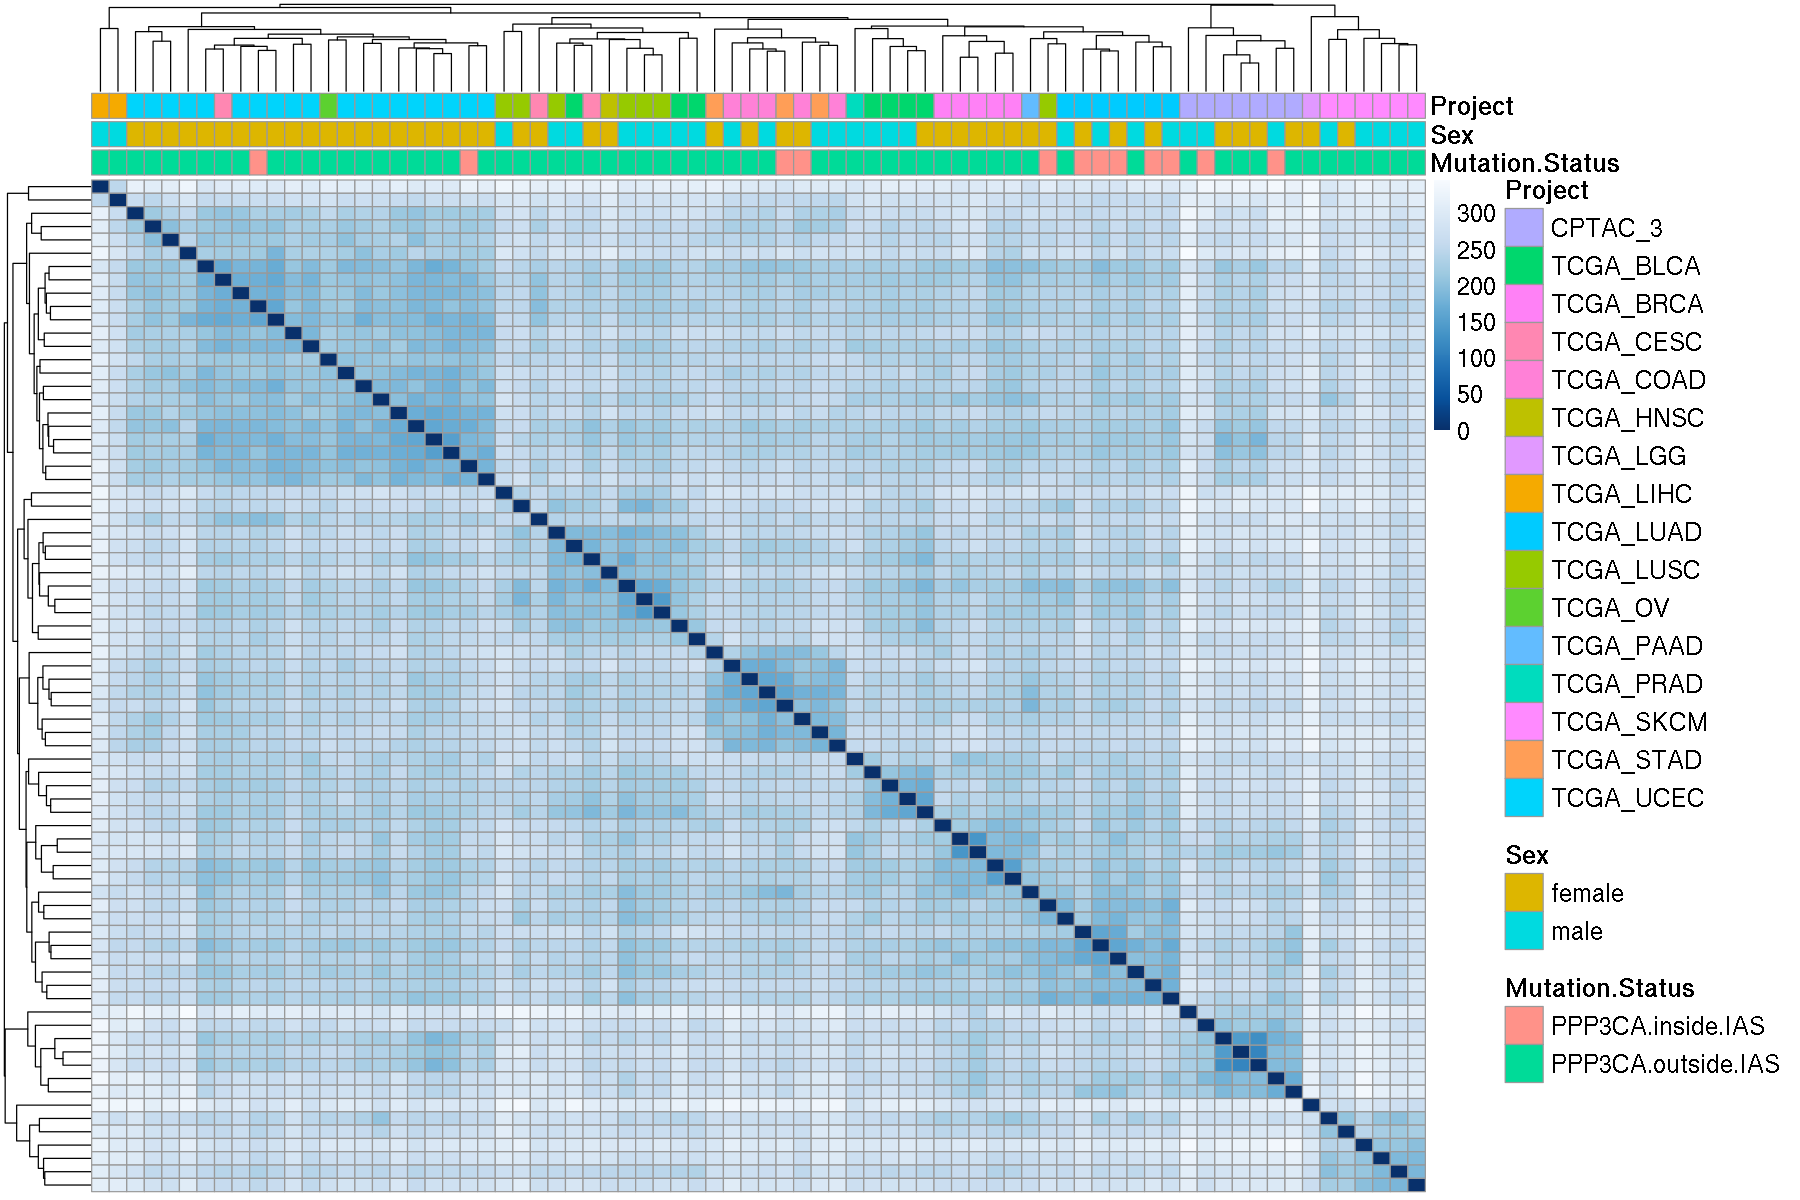

In [47]:
sampleDistMatrix <- as.matrix( sampleDists )
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
annot = data.frame(row.names = row.names(colData(dat_vsd)), Mutation.Status = colData(dat_vsd)[, 'Mutation.Status'], Sex = colData(dat_vsd)[, 'gender'],
                  Project = colData(dat_vsd)[,'Project.ID'])

pheatmap(sampleDistMatrix,
         col = colors, 
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         annotation_col = annot,
         show_rownames=FALSE, 
         show_colnames=FALSE, 
         fontsize=15)

We see that most of the clustering happens at the Project level

### PCA

In [48]:
pcs <- prcomp(t(assay(dat_vsd)), center = TRUE, scale = FALSE)
percentVar <- round(100 * summary(pcs)$importance['Proportion of Variance', ])

kept_meta = c('Mutation.Status', 'gender', 'Project.ID', 'primary_site', 'primary_diagnosis')
prinComp <- as.data.frame(cbind(colData(dat_dds)[kept_meta], 
                                pcs$x[rownames(colData(dat_dds)[kept_meta]), 1:10]))

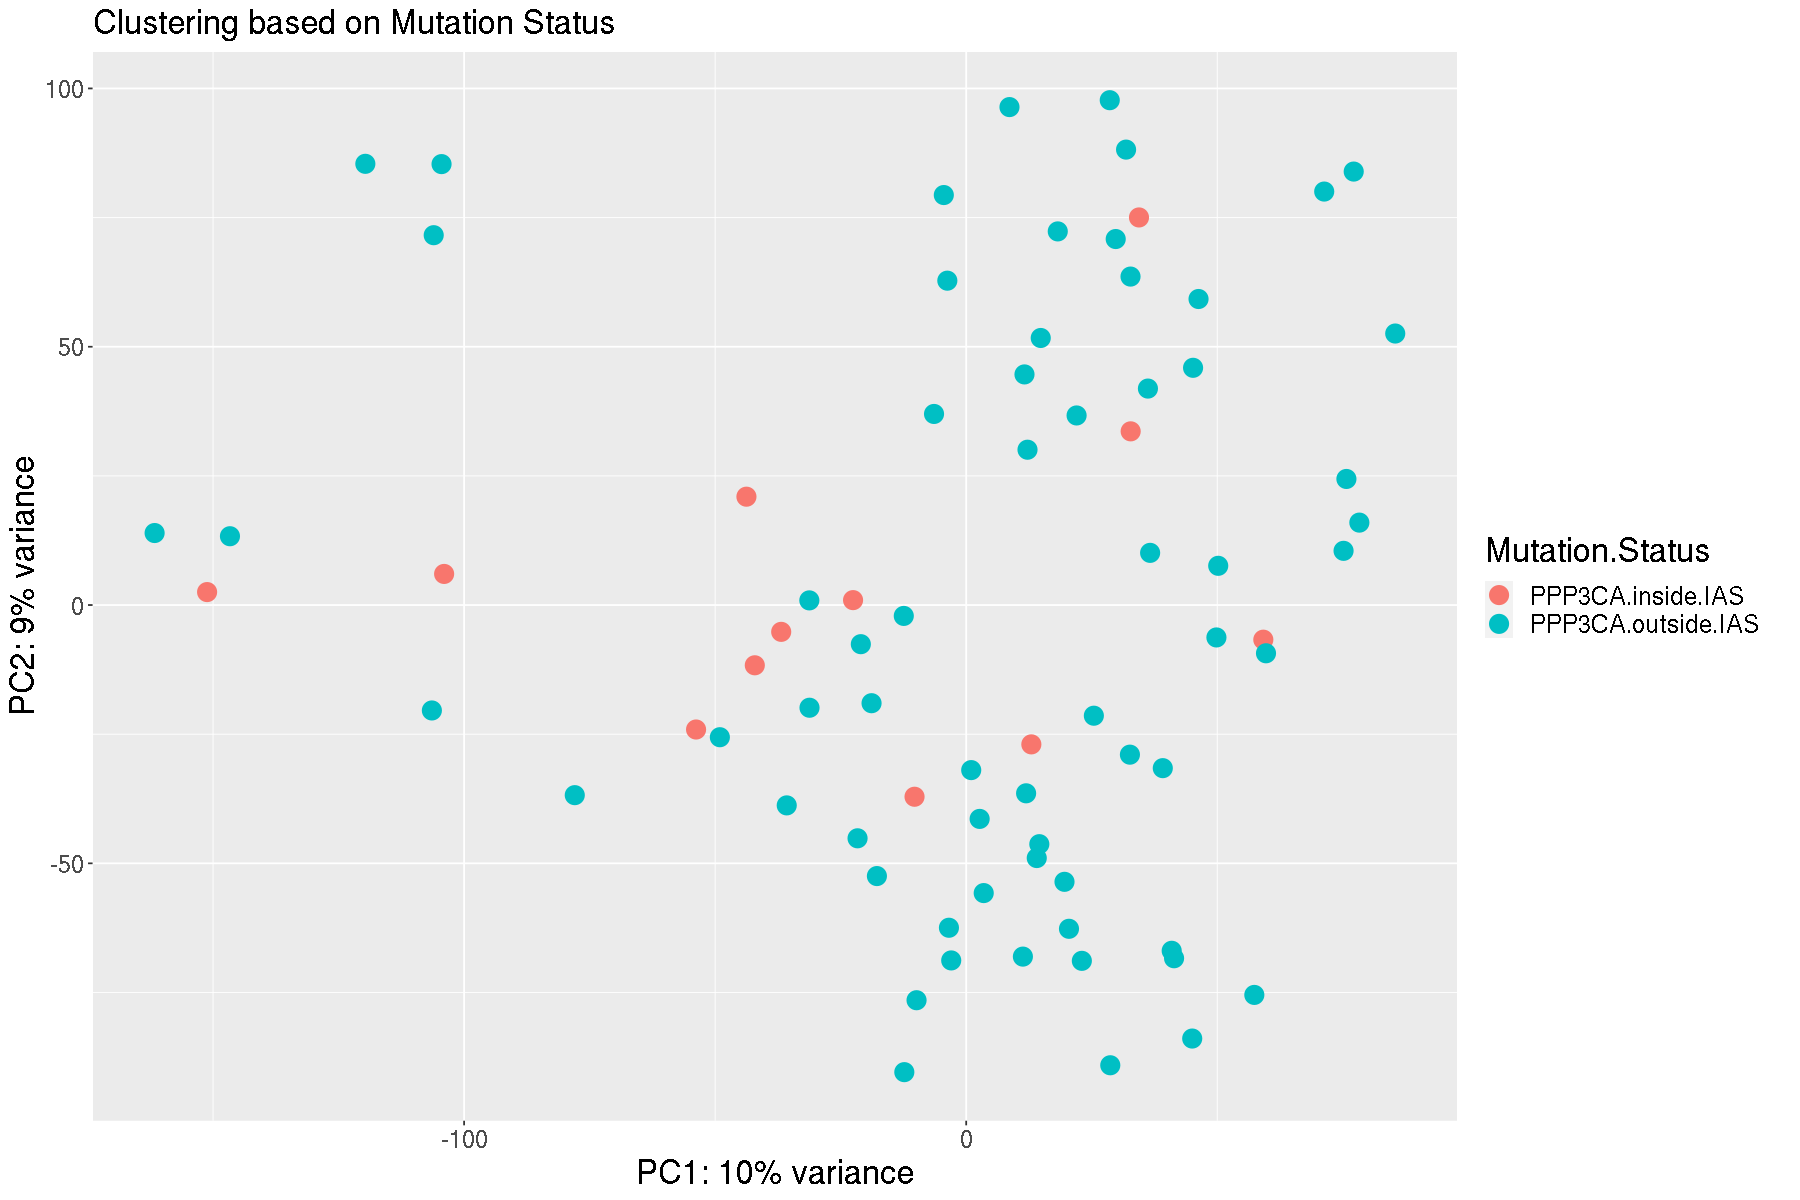

In [49]:
ggplot(prinComp, aes(x = PC1, y = PC2, color = Mutation.Status)) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  geom_point(size=5) + theme(text = element_text(size = 20)) + 
  ggtitle('Clustering based on Mutation Status')

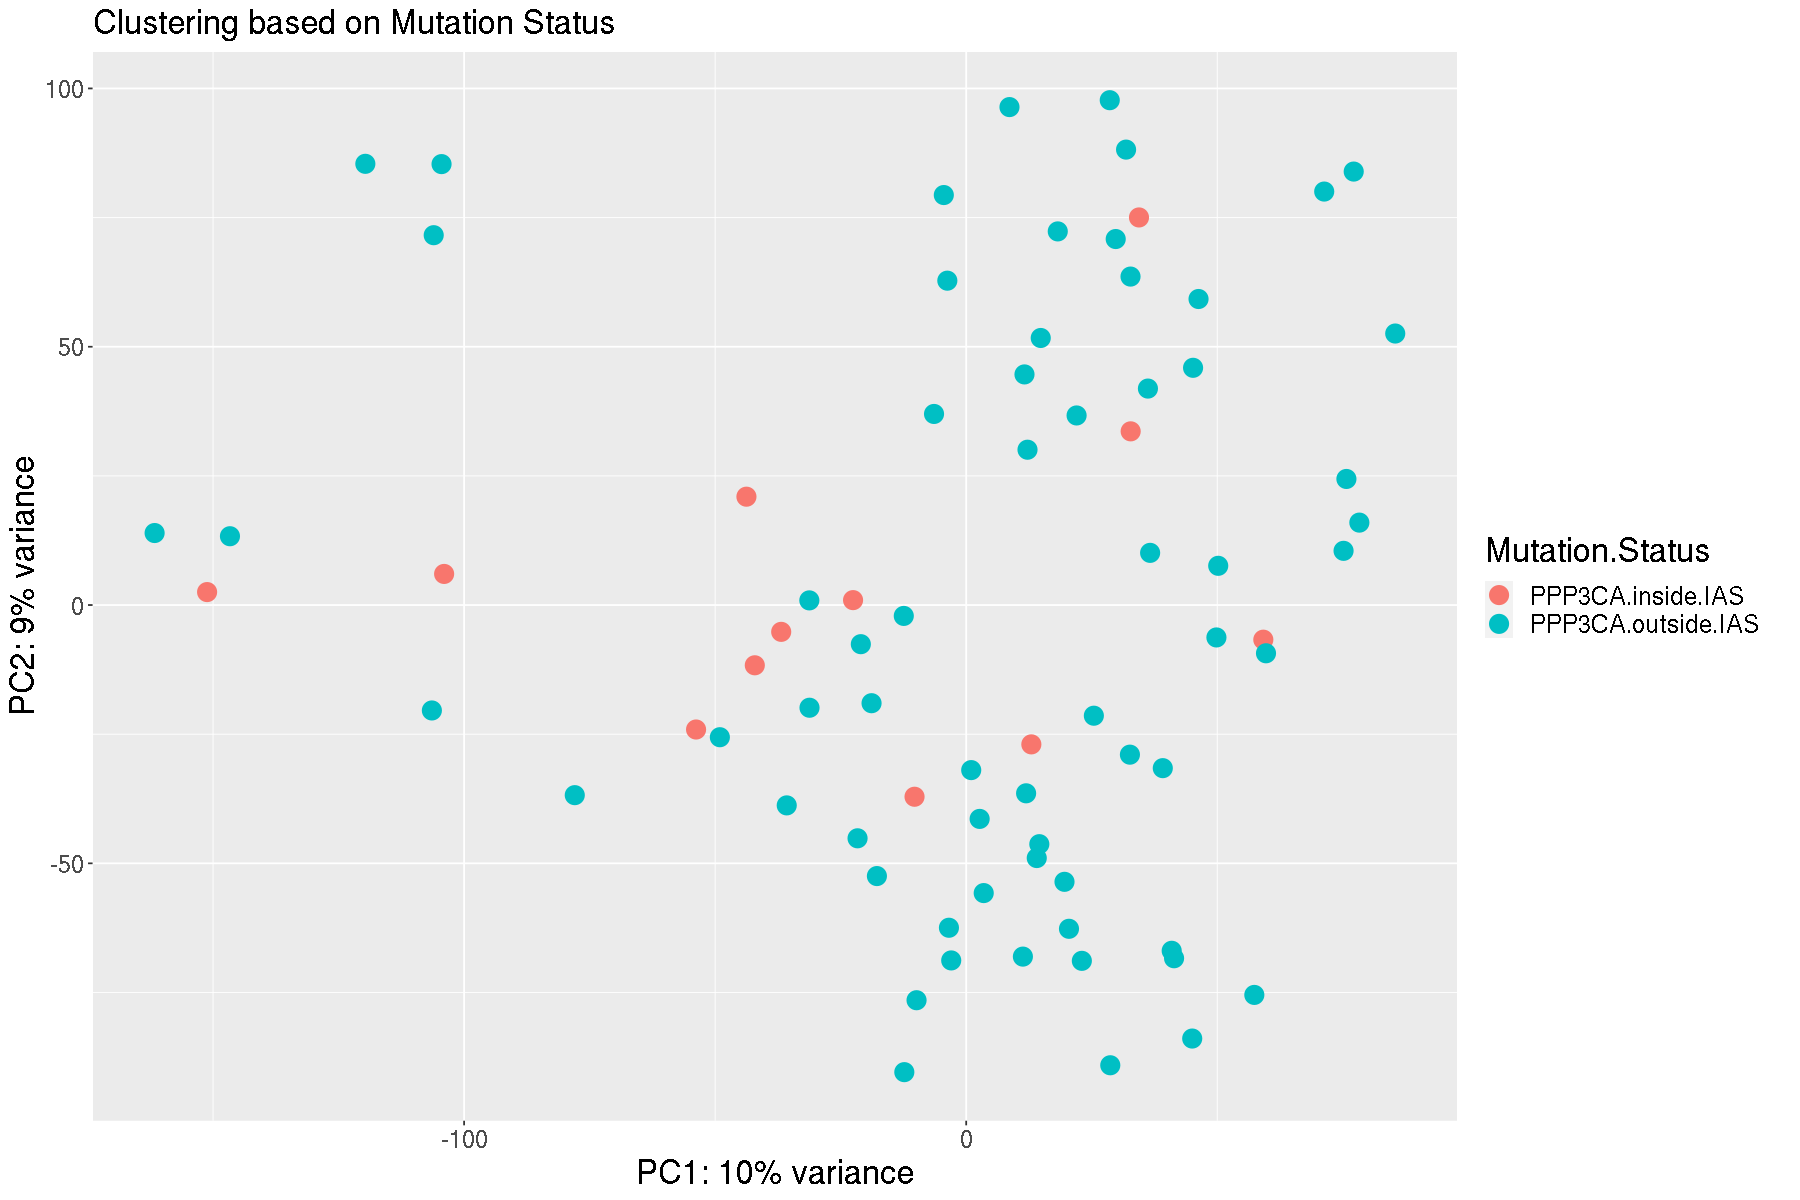

In [50]:
ggplot(prinComp, aes(x = PC1, y = PC2, color = Mutation.Status)) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  geom_point(size=5) + theme(text = element_text(size = 20)) + 
  ggtitle('Clustering based on Mutation Status')

Samples don't seem to cluster based on the mutation status, probably because the different cancer types are a much stronger phenotype, which we will see below. 

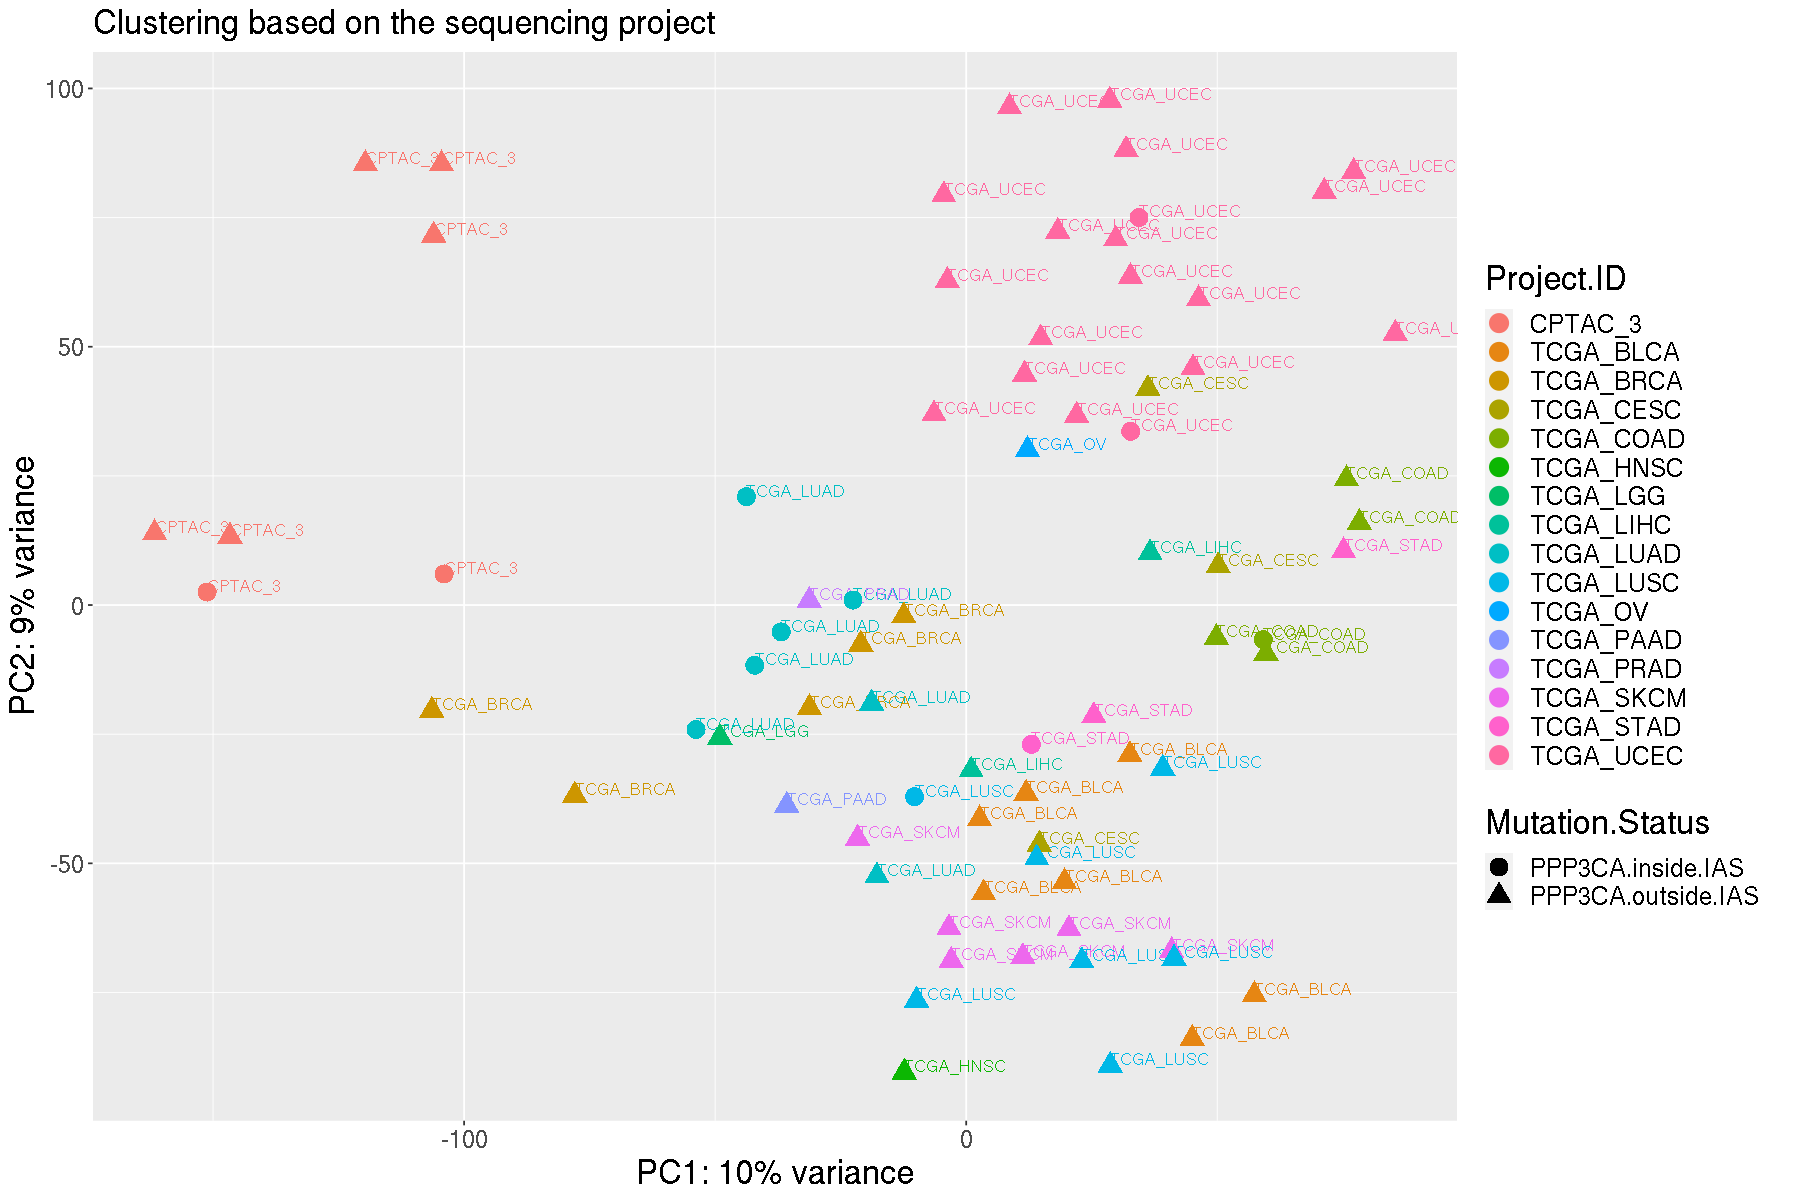

In [51]:
ggplot(prinComp, aes(x = PC1, y = PC2, color = Project.ID, shape = Mutation.Status, label = Project.ID)) + geom_text(hjust=0, vjust=0) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  geom_point(size=5) + theme(text = element_text(size = 20)) +
  ggtitle('Clustering based on the sequencing project')

We see that the samples cluster strongly based on their sequencing project. We will account for this when performing the differential gene expression analysis

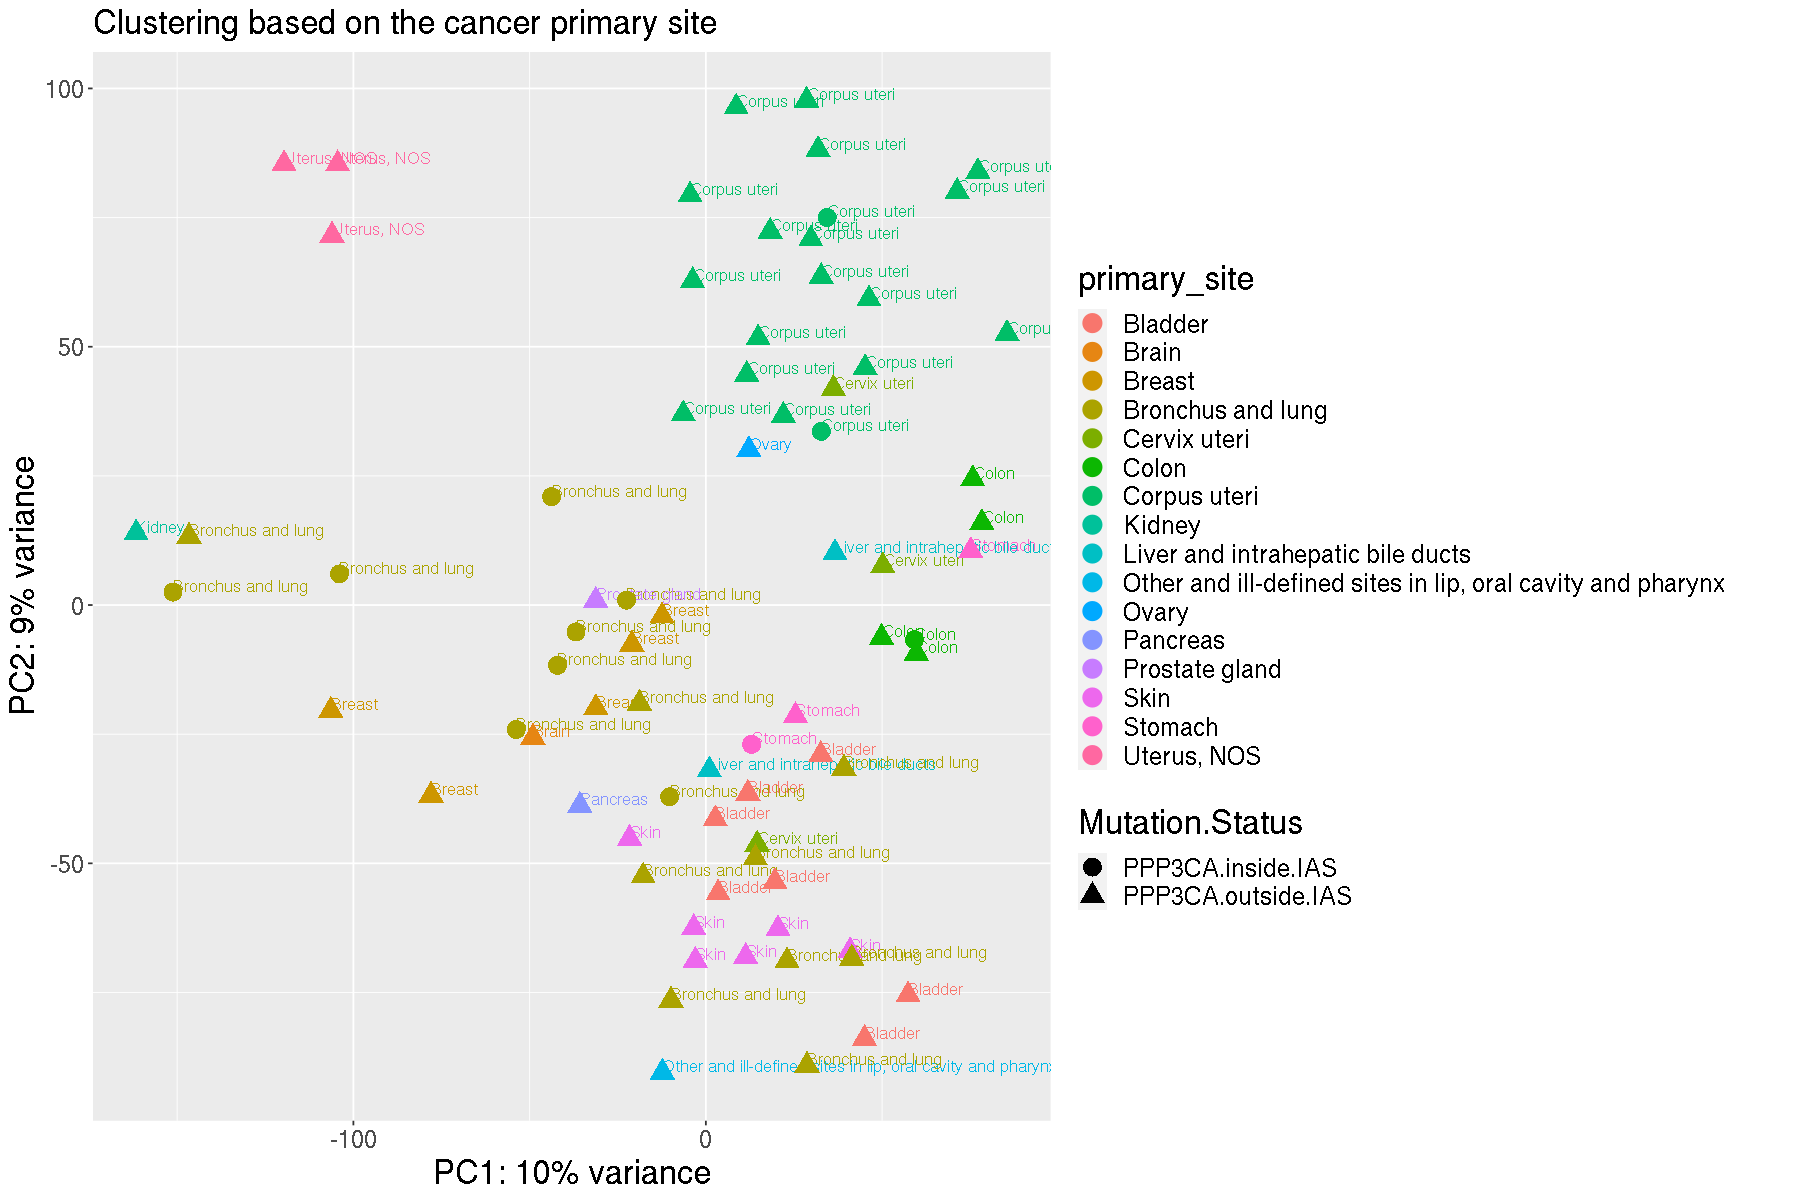

In [52]:
ggplot(prinComp, aes(x = PC1, y = PC2, color = primary_site, shape = Mutation.Status, label = primary_site)) + geom_text(hjust=0, vjust=0) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  geom_point(size=5) + theme(text = element_text(size = 20)) +
  ggtitle('Clustering based on the cancer primary site')

We also see that the samples cluster nicely based on their primary sites 

### RLE Plot

This [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5798764/) suggests the use of Relative log expression (RLE) plots as a way to qualitatively estimate the presence of sources of unwanted variation in high dimensional data, like RNAseq data. The ideal plot has medians centered around zero and whiskers with a small range. 

As we see below, the plot is far from ideal, with strong deviations of the median from zero and with wide ranges of the whiskers. This indicates that some extra steps to account for sources of unwanted variation need to be taken 

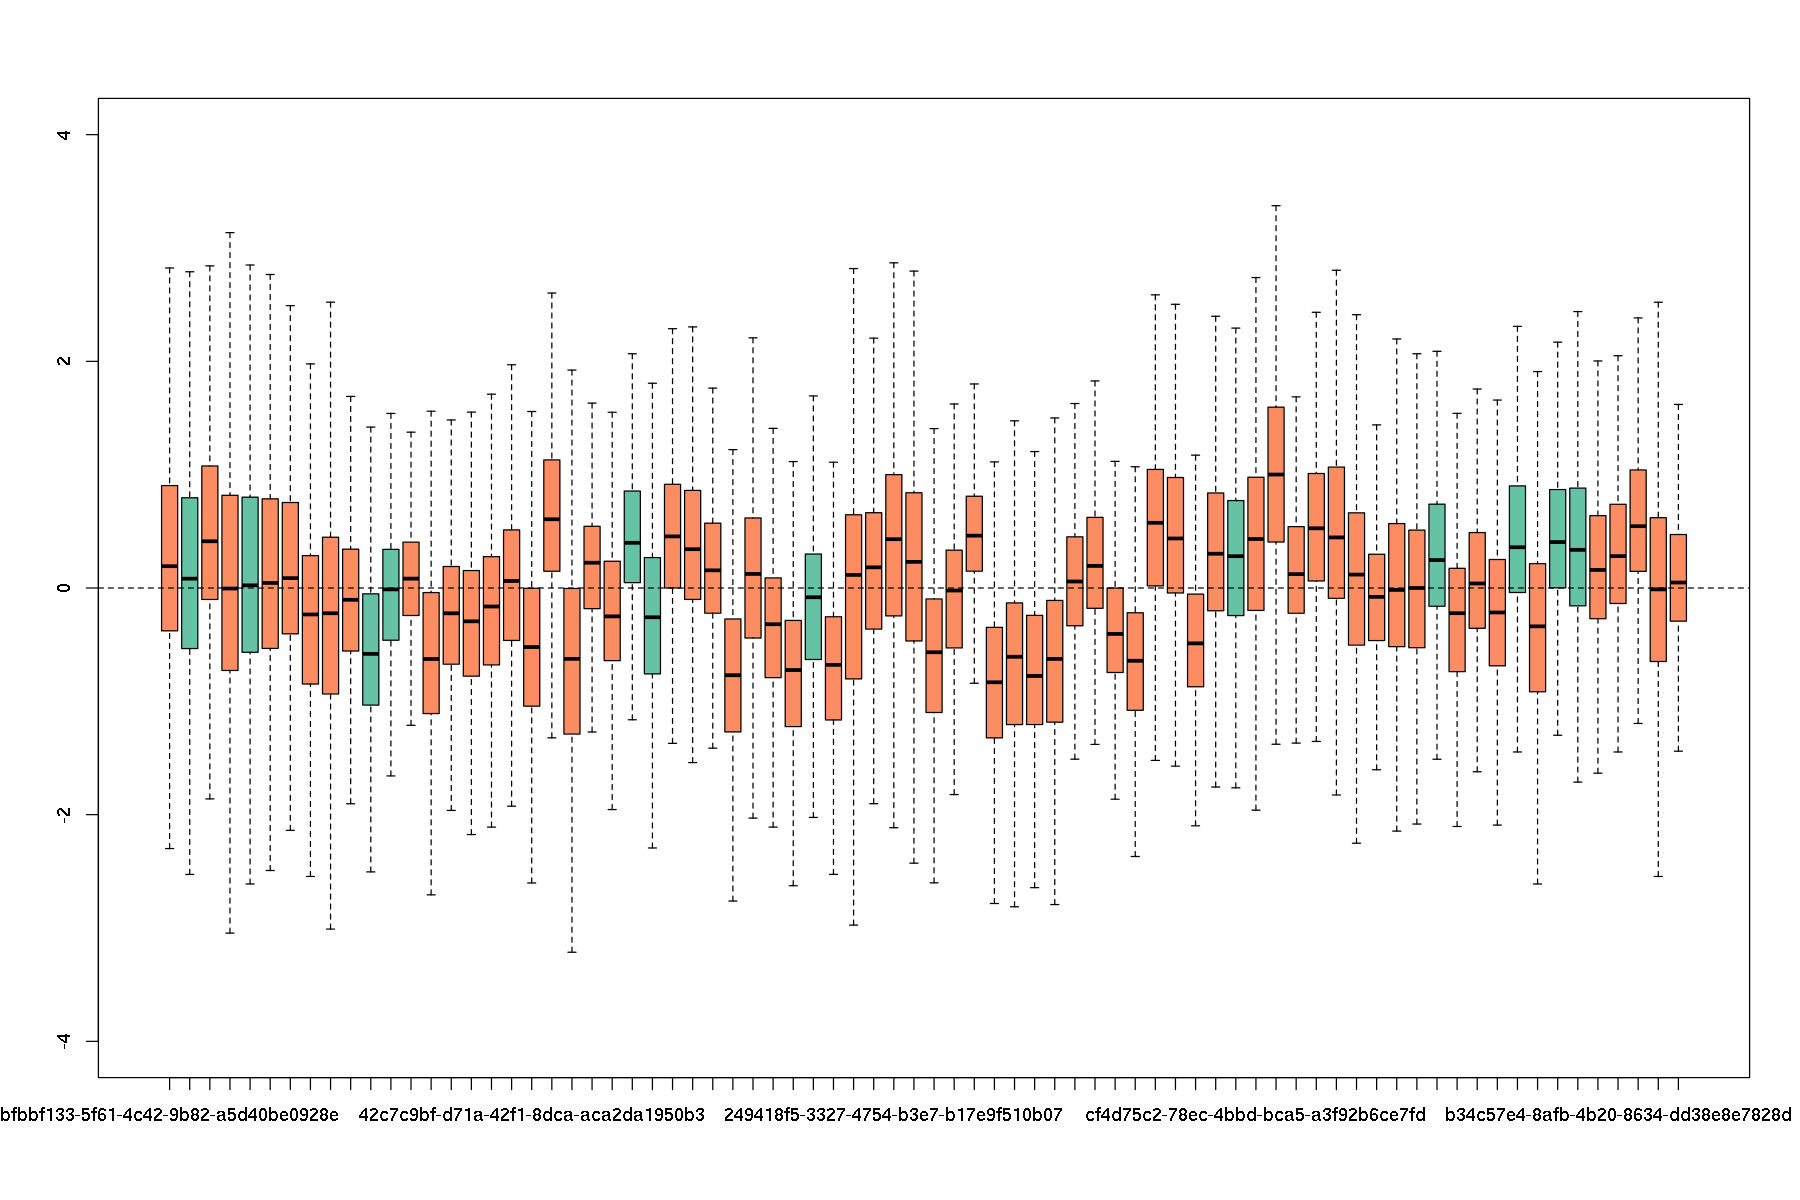

In [53]:
Mutation.Status = colData(dat_dds)$Mutation.Status
colors <- brewer.pal(3, "Set2")
plotRLE(assays(dat_dds)$counts, outline=FALSE, ylim=c(-4, 4), col=colors[Mutation.Status])

RLE is on the y-axis and the samples are on the x-axis. 

## SVA

We use [svaseq](https://academic.oup.com/nar/article/42/21/e161/2903156) to attempt to account for some of the sources of unwanted variation. Briefly, svaseq removes the variation in the data due to the variables of interest, and based on the remaining variation, it builds surrogate variables based on the expression of gene sets that are responsible for that "unwanted" variation. The surrogate variables can then be used as adjustment variable(s) in the differential expression analysis. 

In `svaseq`, the `n.sv` parameter specifies the number of surrogate variables to estimate. One option is to allow the svaseq algorithm to determine that number, another option is to use a user specified number. We will first allow svaseq to determine that number automatically, then we will use the RLE plot to determine which number of `n.sv` produces a plot with less variation

### Unspecified n.sv

In [54]:
dat_dds <- estimateSizeFactors(dat_dds)
dat_sva  <- counts(dat_dds, normalized = TRUE)
mod  <- model.matrix(~ Project.ID + Mutation.Status, colData(dat_dds))
mod0 <- model.matrix(~ Project.ID, colData(dat_dds))
svseq <- svaseq(dat_sva, mod, mod0)

Number of significant surrogate variables is:  17 
Iteration (out of 5 ):1  2  3  4  5  

In [55]:
number_svs = ncol(svseq$sv)
number_svs

[1] 17

Remove the unwanted variation from the RNA-seq data

In [56]:
newV = NULL
clean_dat_sva_2 = fsva(log(dat_sva+1), mod, svseq, newdat = NULL, method="exact")
clean_dat_sva_2$db = round(exp(clean_dat_sva_2$db) - 1)
clean_dat_sva_2$db[clean_dat_sva_2$db<0] <- 0

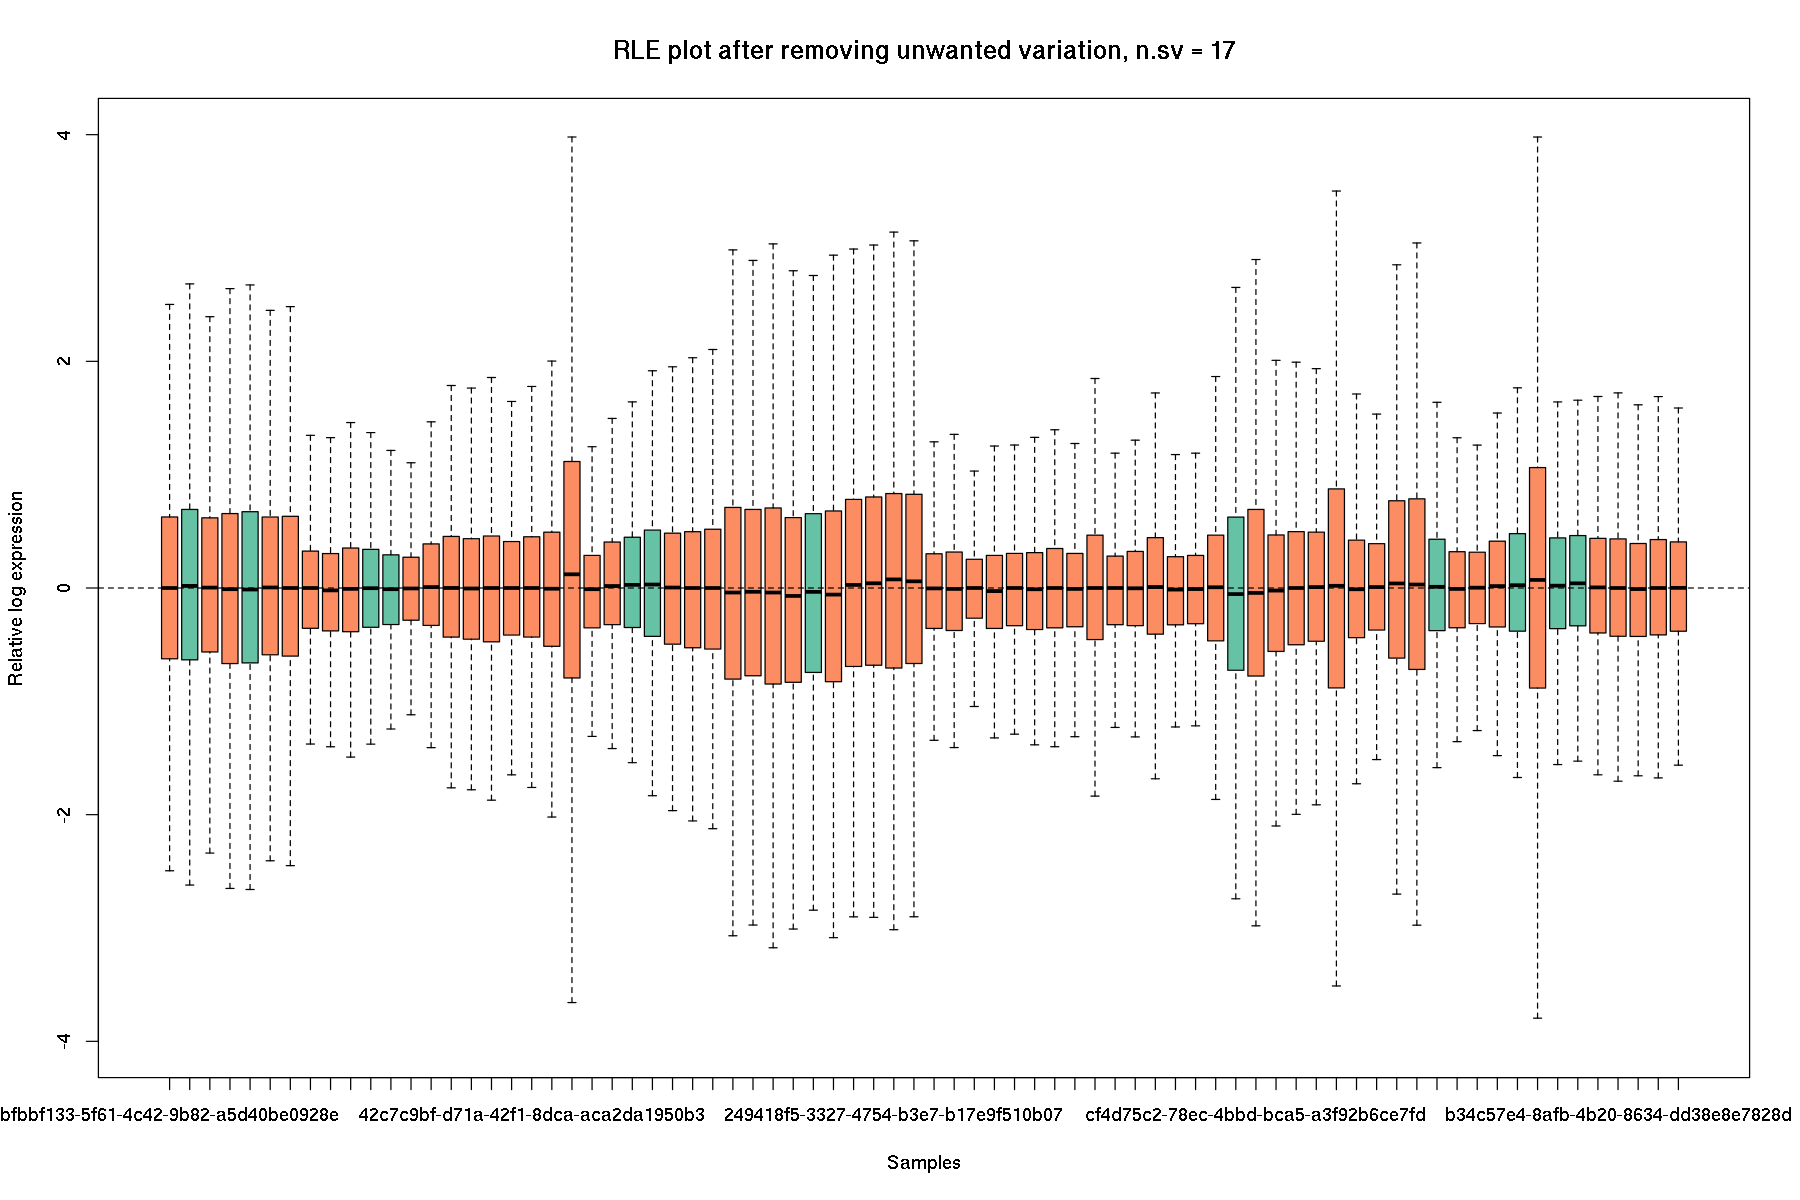

In [57]:
colors <- brewer.pal(3, "Set2") # n.sv = 17
plotRLE(clean_dat_sva_2$db, outline=FALSE, ylim=c(-4, 4), 
        col=colors[colData(dat_dds)$Mutation.Status], xlab='Samples', ylab='Relative log expression',
        main='RLE plot after removing unwanted variation, n.sv = 17')

We see that using n.sv = 17 results in a RLE plot with medians nicely centered around zero, but with very large ranges of the whiskers. Below we will try to use a more suitable and smaller number of n.sv

### Specified n.sv

Below we create RLE plots with increasing numbers of n.sv, starting at 1 and ending with 10. This will allow us to select a good parameter.

Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

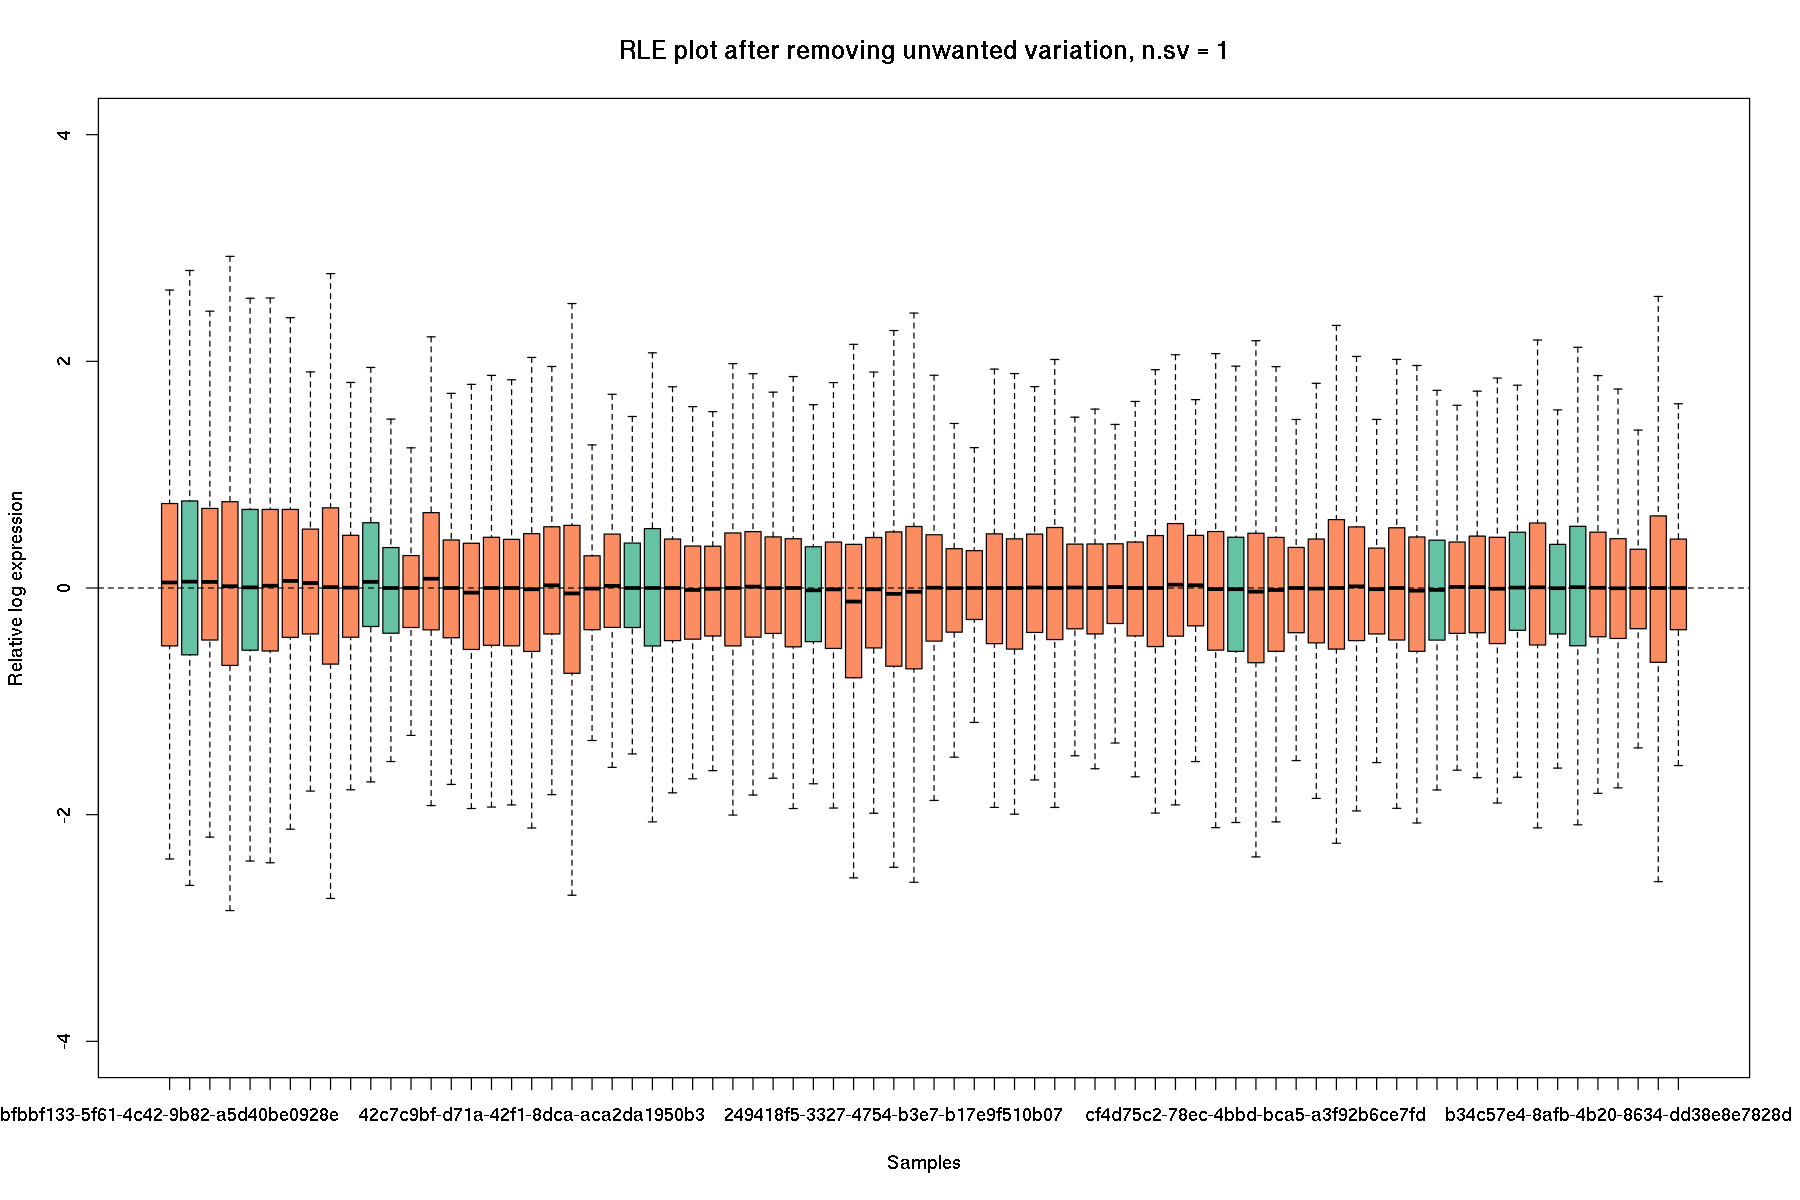

Number of significant surrogate variables is:  3 
Iteration (out of 5 ):1  2  3  4  5  

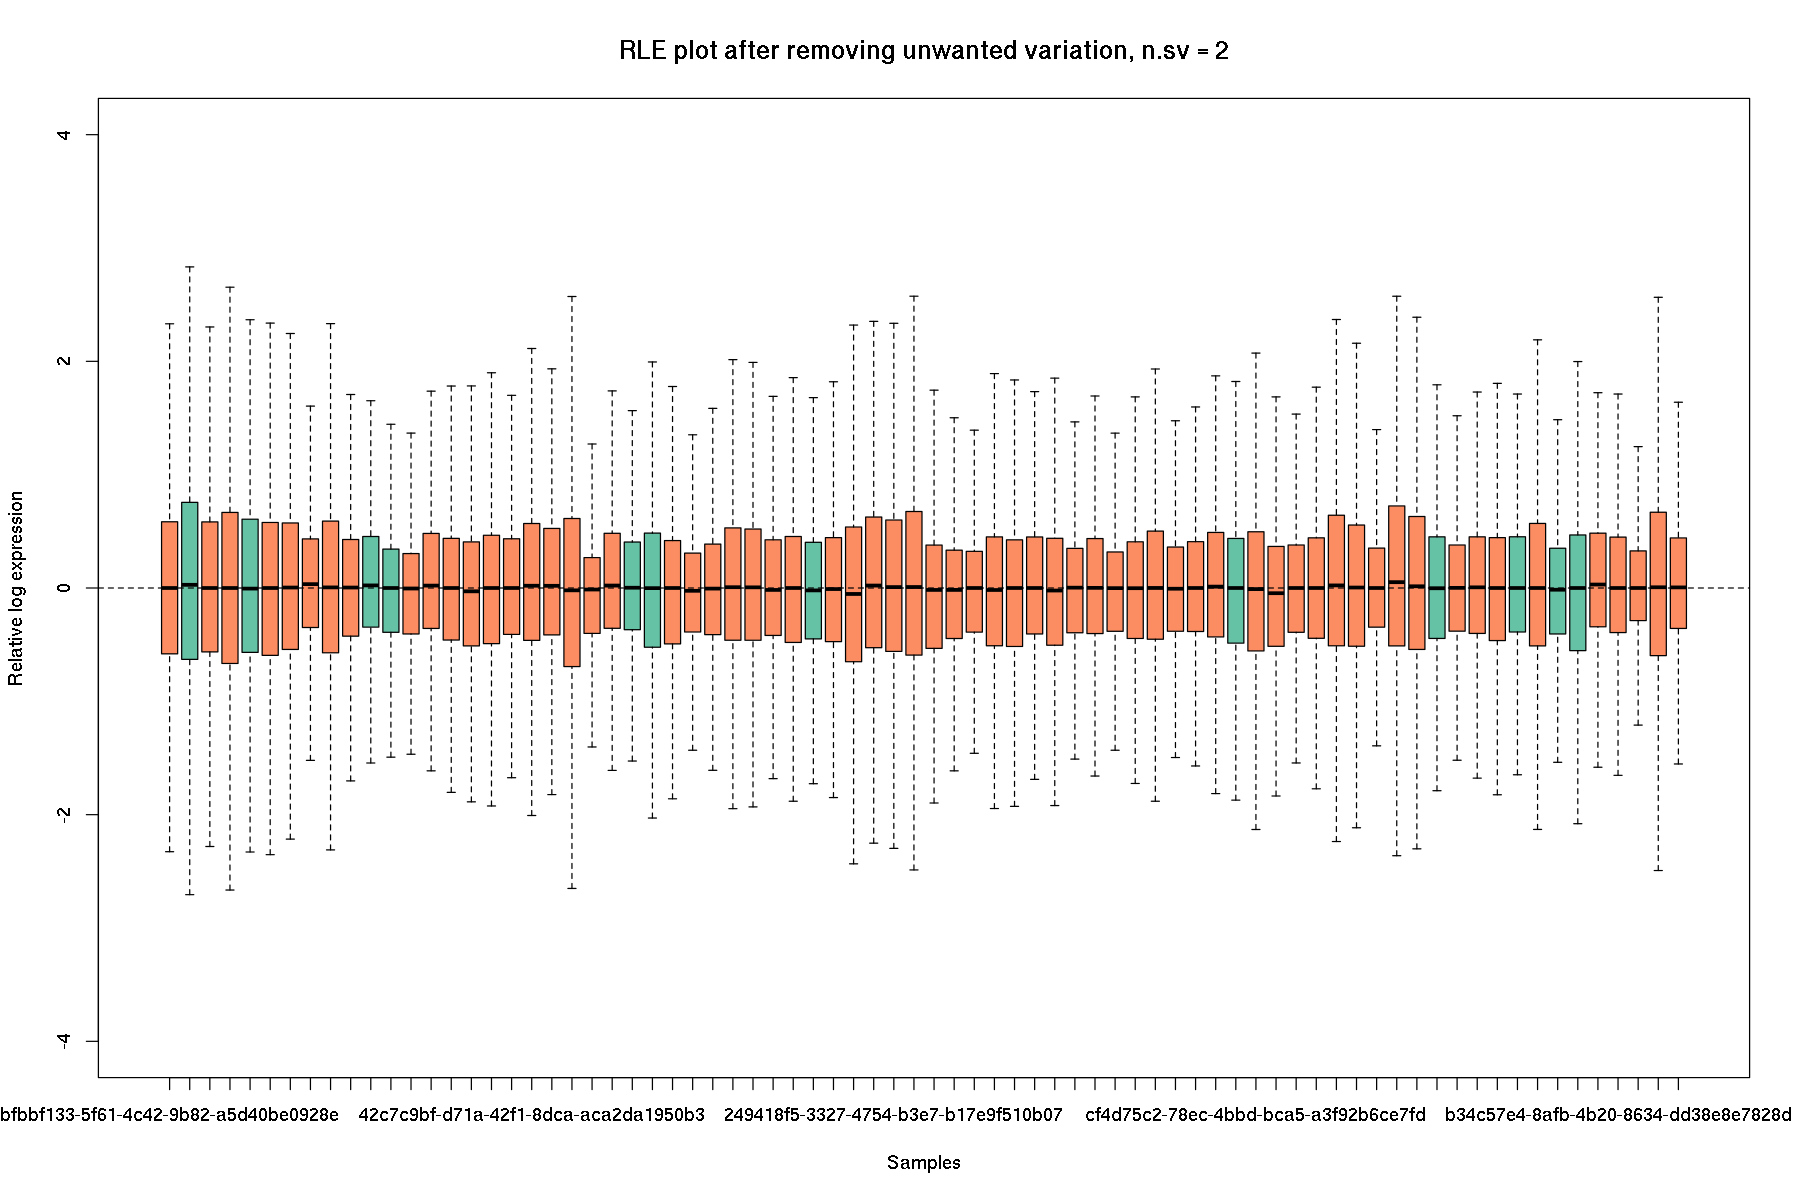

Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  

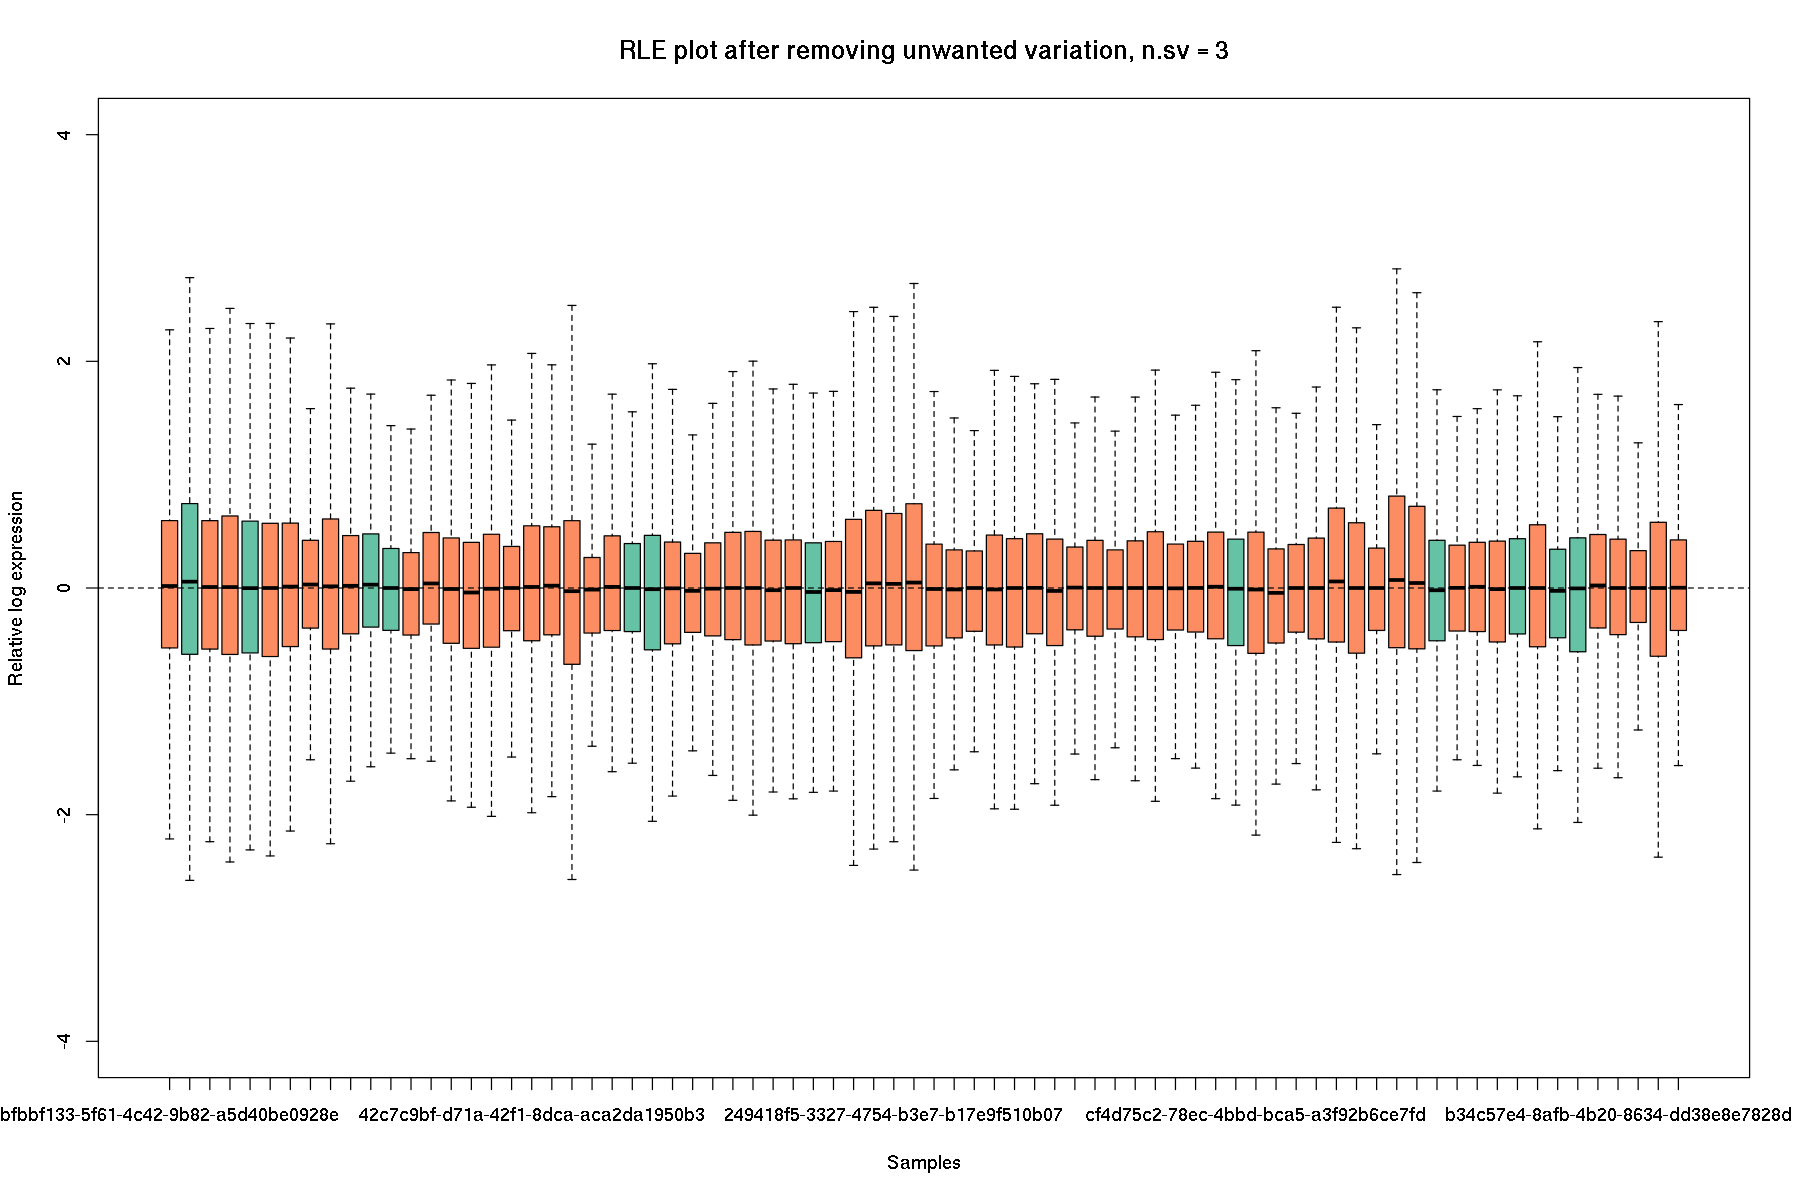

Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  

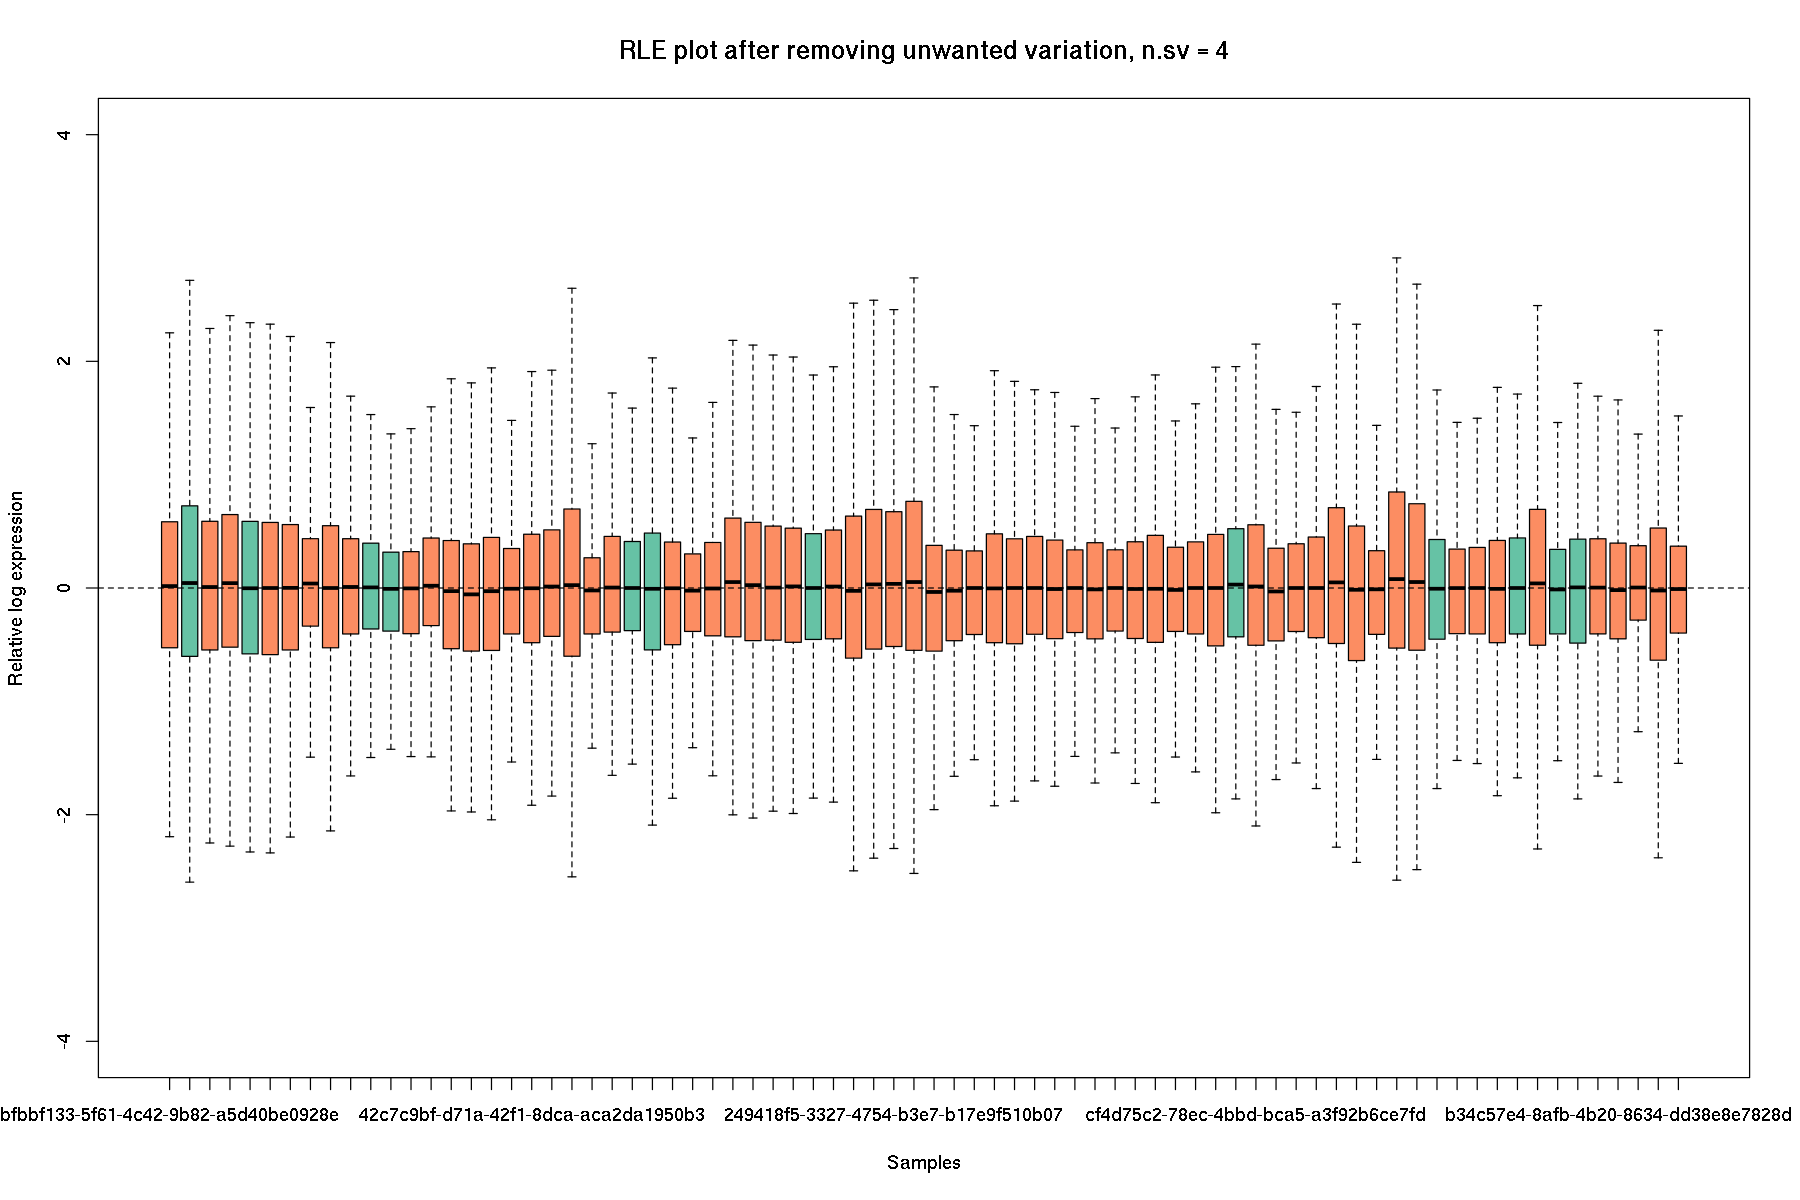

Number of significant surrogate variables is:  6 
Iteration (out of 5 ):1  2  3  4  5  

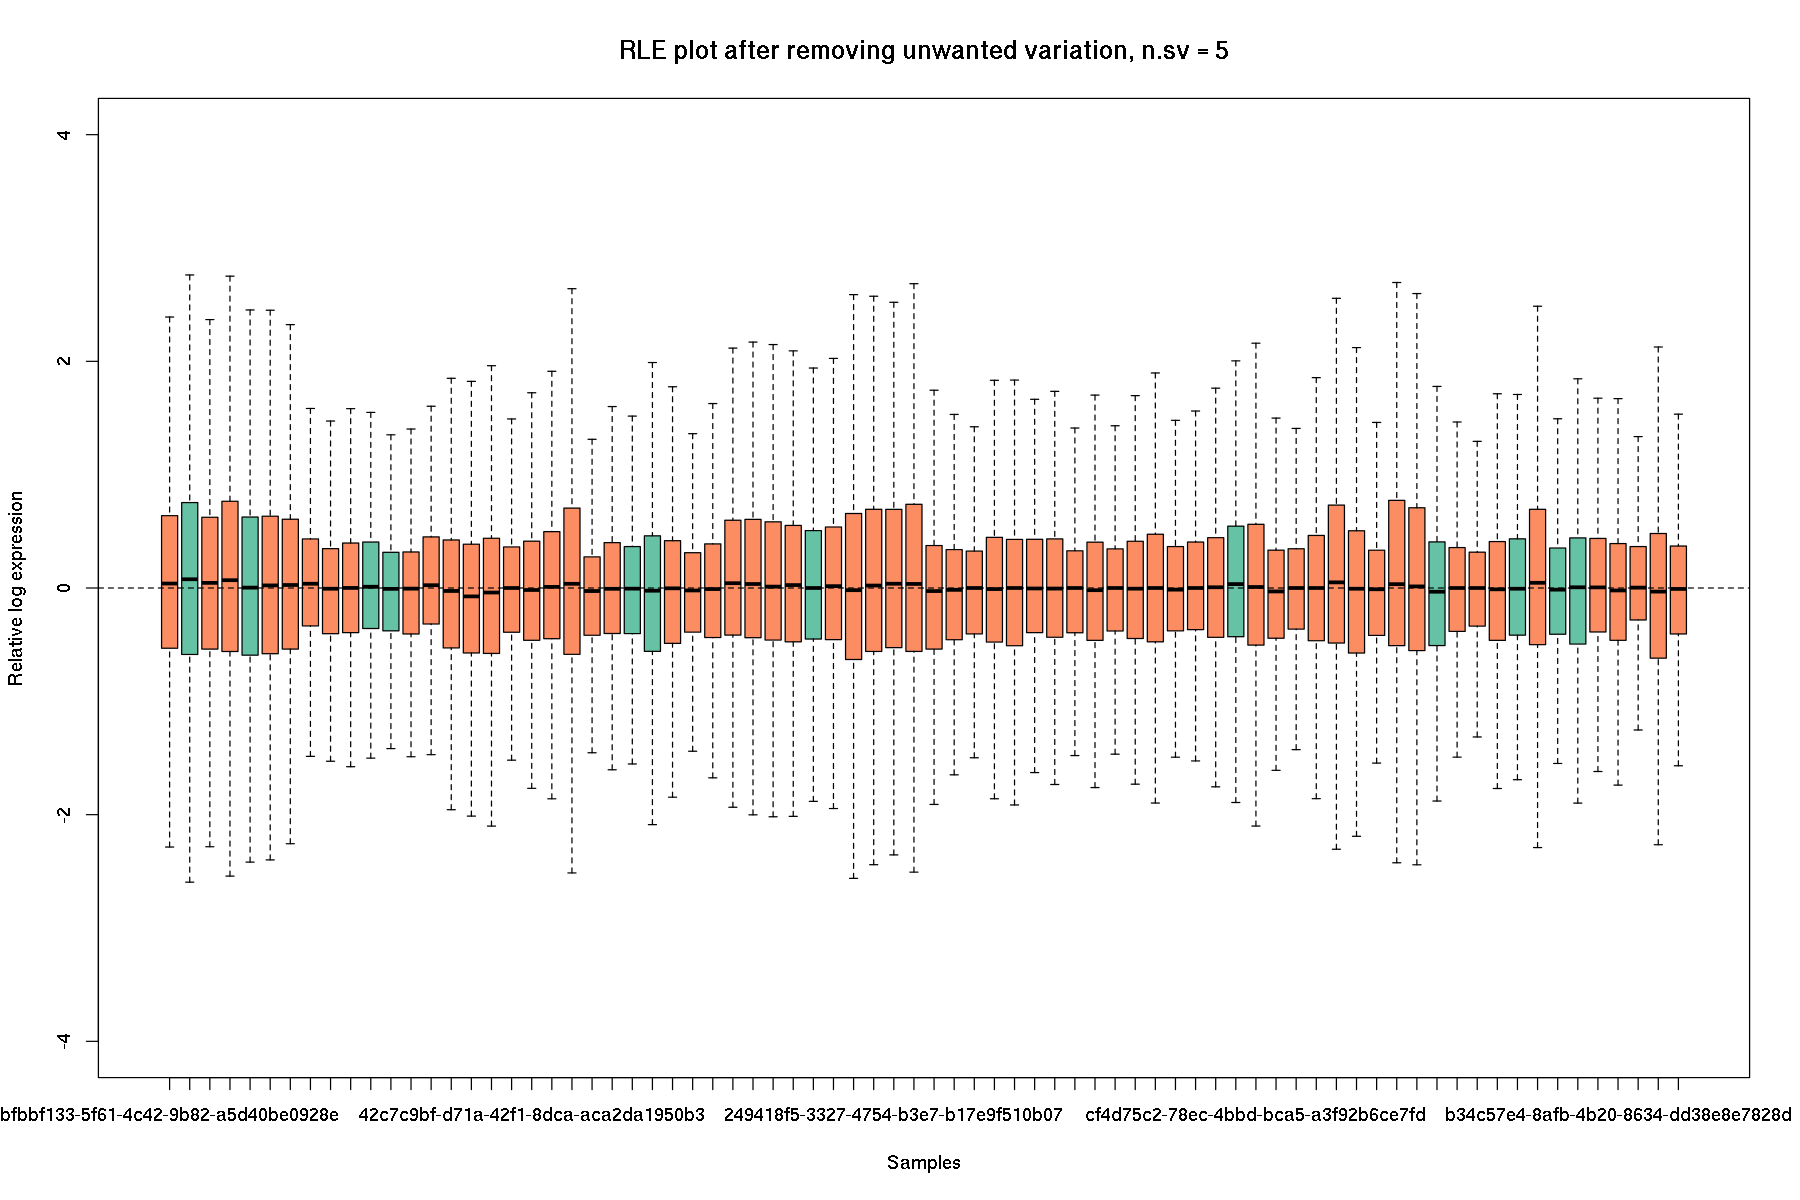

Number of significant surrogate variables is:  7 
Iteration (out of 5 ):1  2  3  4  5  

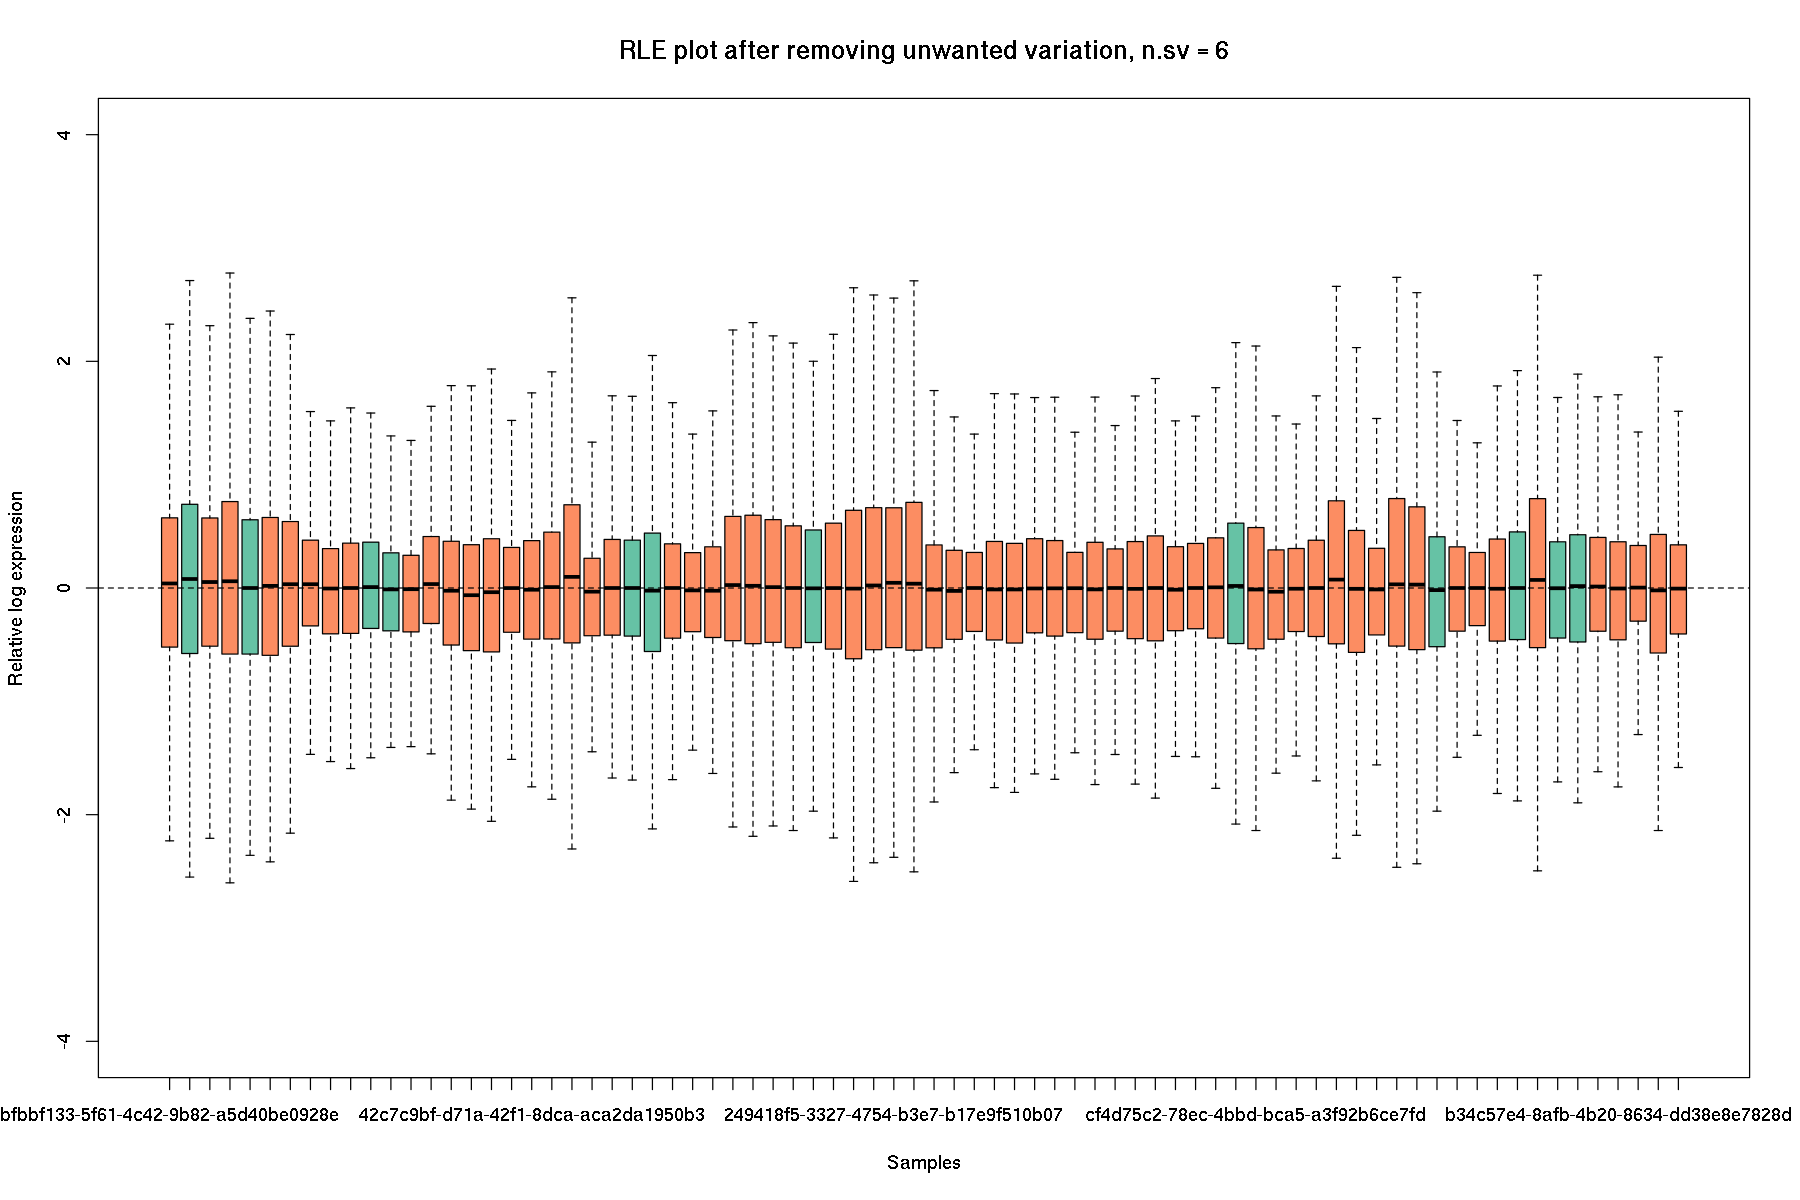

Number of significant surrogate variables is:  8 
Iteration (out of 5 ):1  2  3  4  5  

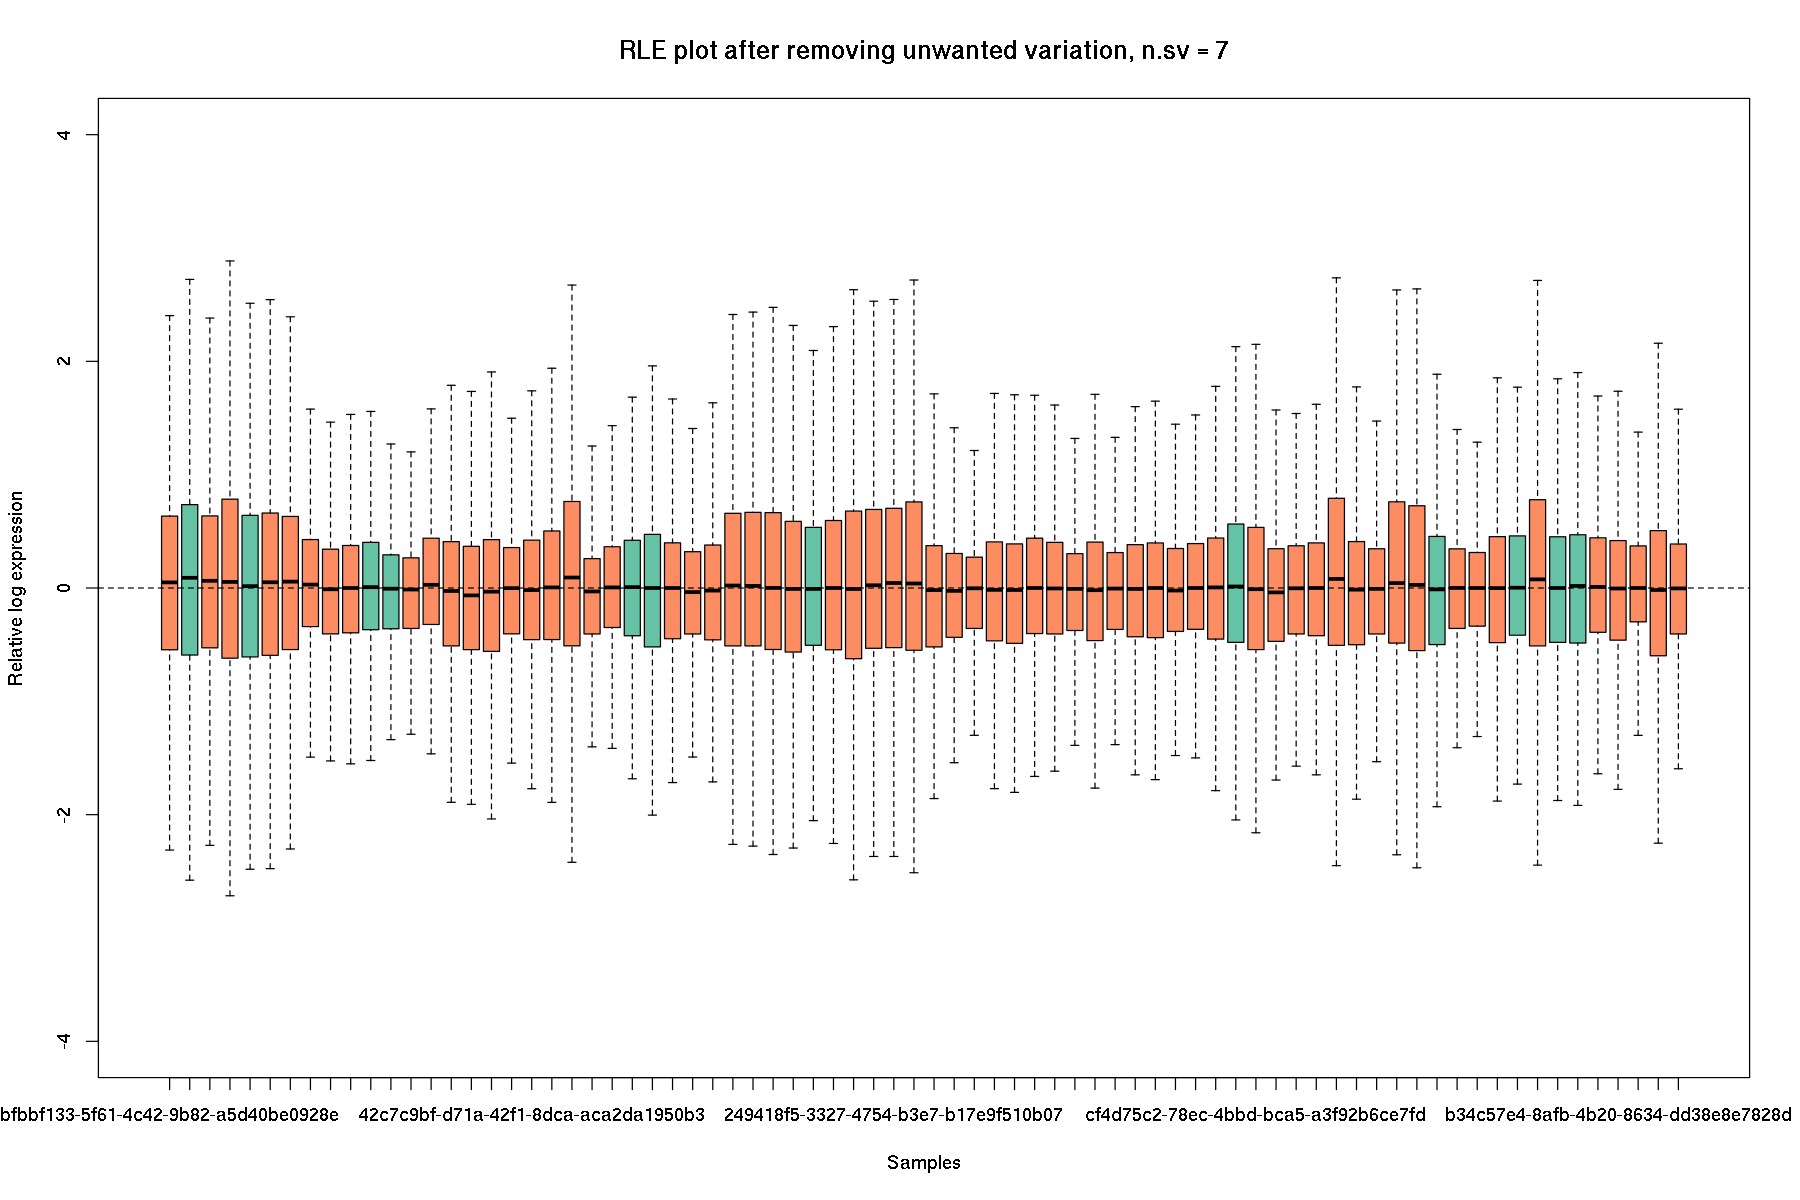

Number of significant surrogate variables is:  9 
Iteration (out of 5 ):1  2  3  4  5  

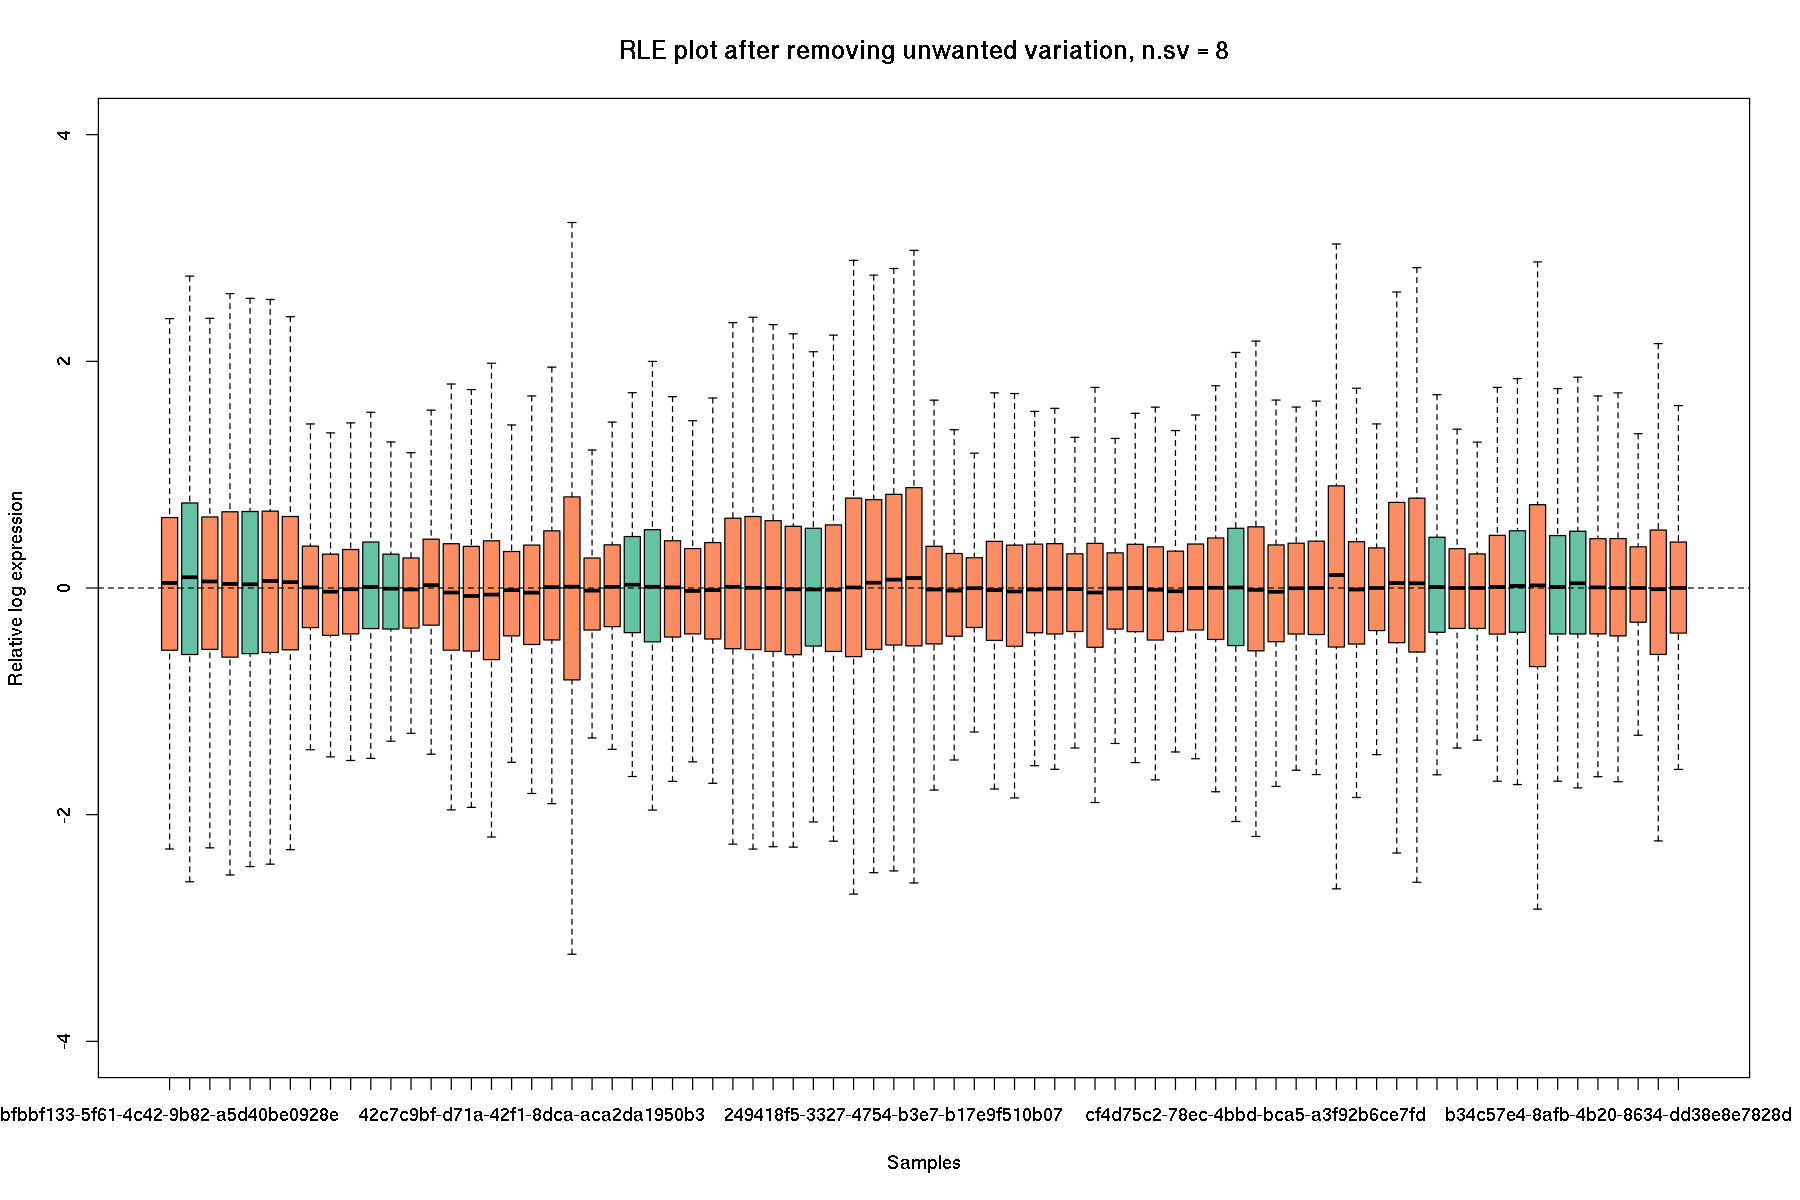

Number of significant surrogate variables is:  10 
Iteration (out of 5 ):1  2  3  4  5  

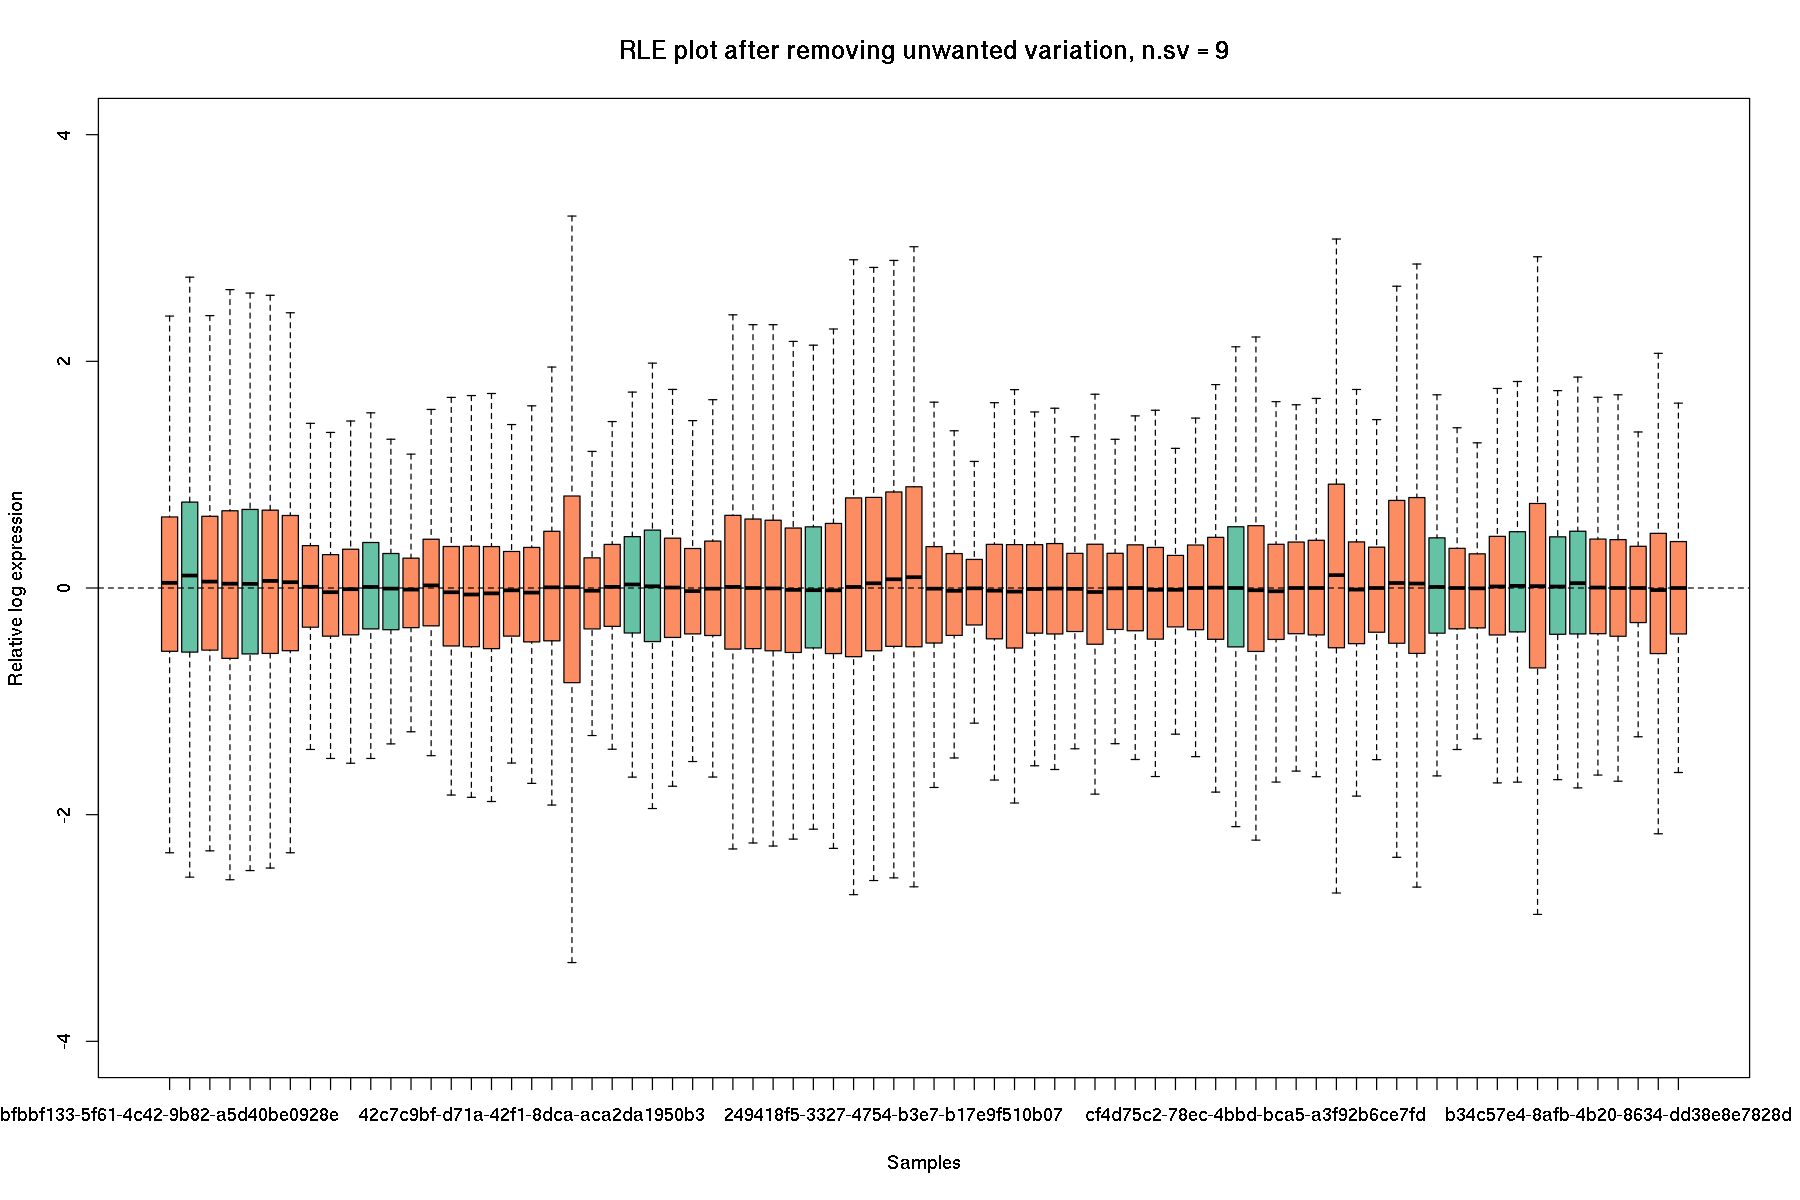

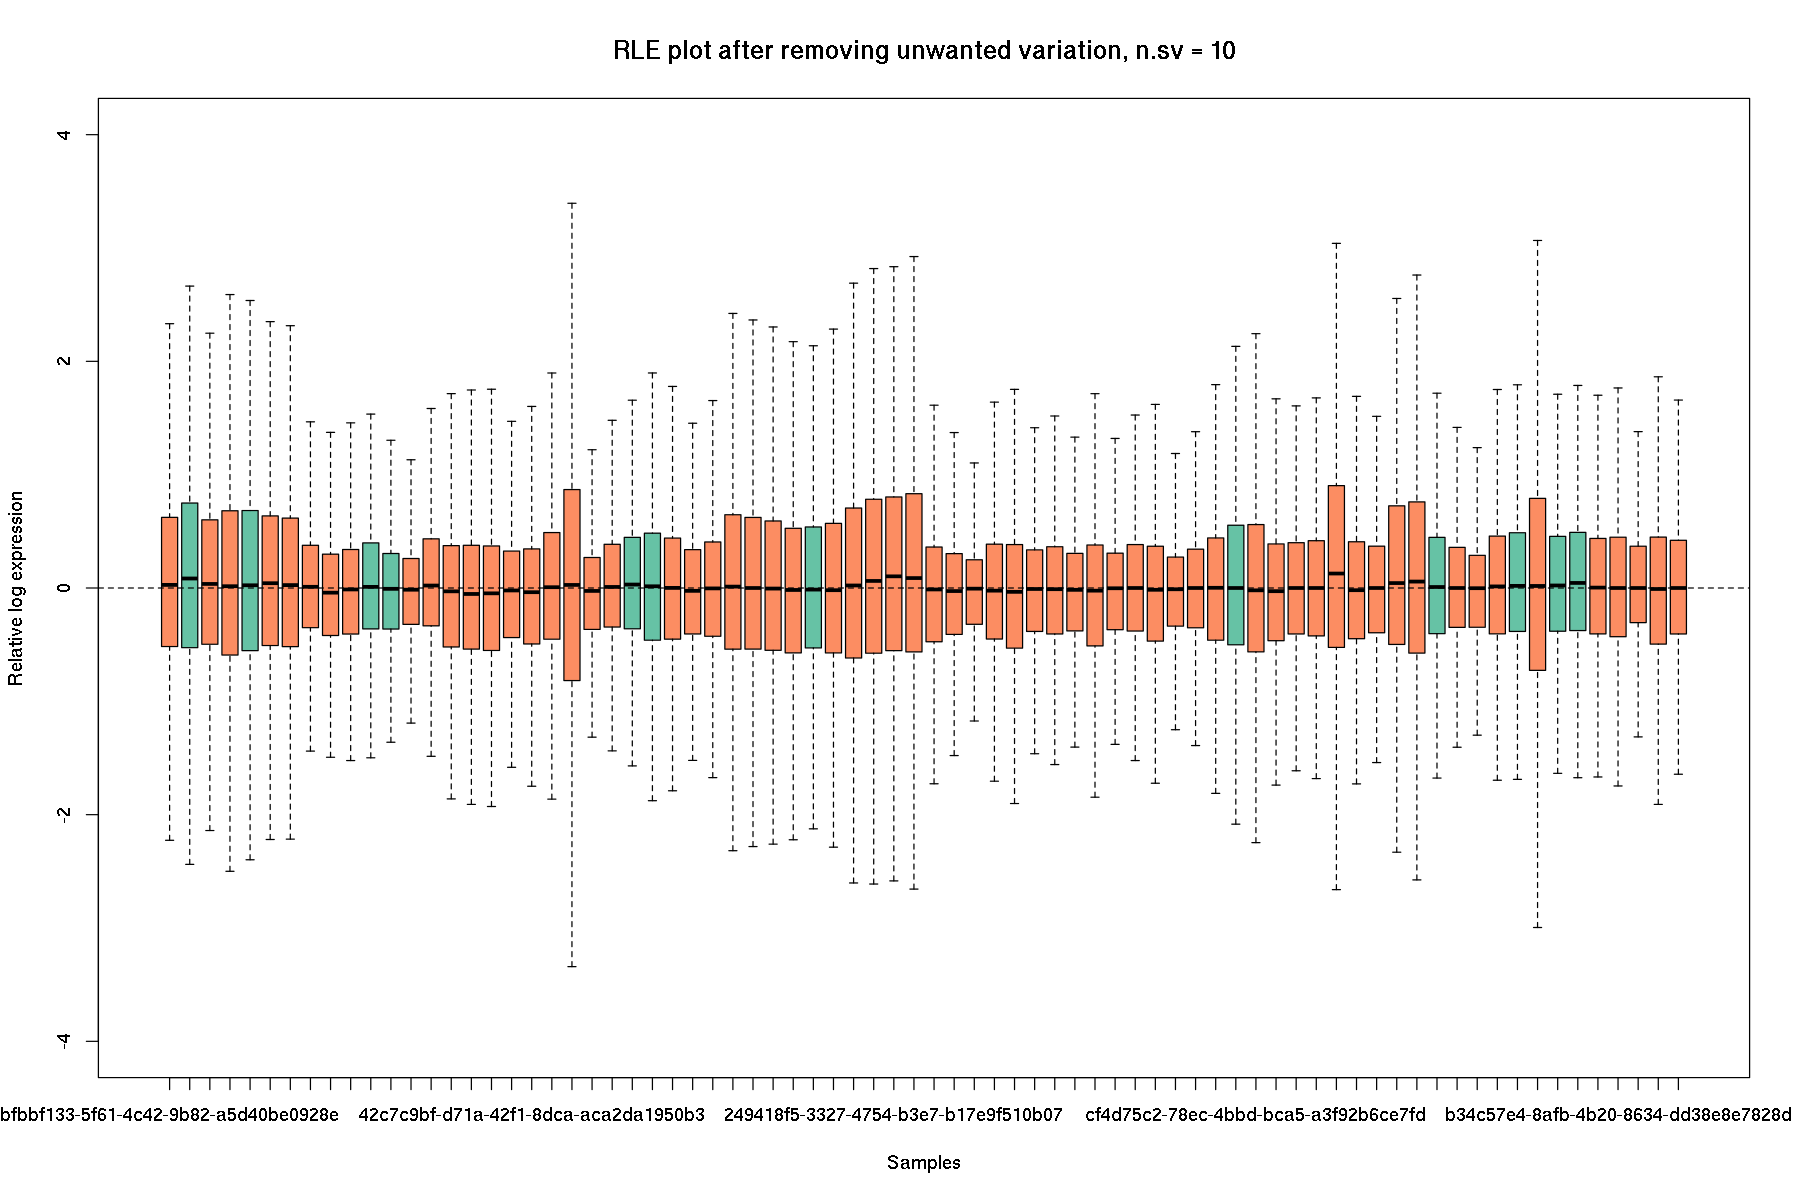

In [58]:
for (i in 1:10){
    temp_svseq <- svaseq(dat_sva, mod, mod0, n.sv=i)
    
    newV = NULL
    clean_dat_sva_temp = fsva(log(dat_sva+1), mod, temp_svseq, newdat = NULL, method="exact")
    clean_dat_sva_temp$db = round(exp(clean_dat_sva_temp$db) - 1)
    clean_dat_sva_temp$db[clean_dat_sva_temp$db<0] <- 0
    
    plotRLE(clean_dat_sva_temp$db, outline=FALSE, ylim=c(-4, 4), 
            col=colors[colData(dat_dds)$Mutation.Status], xlab='Samples', ylab='Relative log expression',
            main=paste('RLE plot after removing unwanted variation, n.sv =', i))
}

### Make a decision on n.sv

Based on the plots above, n.sv = 2 produces a plot with better centering around zero than with n.sv = 1. As we increase n.sv the plots don't seem to change much. So we choose n.sv = 2. 

In [59]:
dat_dds <- estimateSizeFactors(dat_dds)
dat_sva  <- counts(dat_dds, normalized = TRUE)
mod  <- model.matrix(~ Project.ID + Mutation.Status, colData(dat_dds))
mod0 <- model.matrix(~ Project.ID, colData(dat_dds))
svseq <- svaseq(dat_sva, mod, mod0, n.sv=2)

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [60]:
svseq$sv = as.data.frame(svseq$sv)
colnames(svseq$sv) = paste0('SV', c(1:ncol(svseq$sv)))

## Differential Expression Analysis - n.sv = 2

In [61]:
# Add the surrogate variables to the DESeq object
colData(dat_dds)$SV1 = svseq$sv$SV1
colData(dat_dds)$SV2 = svseq$sv$SV2

In [62]:
# Set the order of the Mutation.Status factor
colData(dat_dds)$Mutation.Status = factor(colData(dat_dds)$Mutation.Status, 
                                          levels = c(paste0(gene, '.outside.IAS'), 
                                                     paste0(gene, '.inside.IAS')))

We will perform a differential expression analysis to find the genes differentially expressed according to the Mutation.Status, while adjusting for changes in expression due to the surrogate variables and the different sequencing projects where the samples came from 

In [63]:
design(dat_dds) = ~ SV1 + SV2 + Project.ID + Mutation.Status

In [64]:
dat_dds = DESeq(dat_dds)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

343 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest



In [65]:
# dat_dds = readRDS('../../RNAseq/data/dea/pancancer/rds/PPP3CA.sva.dea.rds')

In [66]:
res05 = results(dat_dds, alpha=0.05)

In [67]:
summary(res05)


out of 20869 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 75, 0.36%
LFC < 0 (down)     : 62, 0.3%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



We use the `apeglm` method to shrink the log2 fold change estimates

In [68]:
dat_res <- lfcShrink(dat_dds, coef=paste0("Mutation.Status_", gene, ".inside.IAS_vs_", gene, ".outside.IAS"), 
                     type="apeglm", res = res05)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [69]:
# Create a dataframe with the results and add the gene name and gene id
results <- as.data.frame(dat_res)
results$gene_name = rowData(dat_dds)$gene_name
results$gene_id = row.names(results)

In [70]:
# Uncomment if you want to save the differential expression analysis results
# write.table(results, paste0('../data/results.', gene, '.tsv'), sep='\t', row.names = FALSE)

In [71]:
results_keep = results[which(results$padj<=0.05 & abs(results$log2FoldChange)>=1.5),]
results_keep = results_keep[order(-abs(results_keep$log2FoldChange)),]

In [72]:
results_keep

,baseMean,log2FoldChange,lfcSE,pvalue,padj,gene_name,gene_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
ENSG00000166961.15,151.39455,3.953857,1.3935545,5.335215e-06,3.554353e-03,MS4A15,ENSG00000166961.15
ENSG00000188338.15,1231.68832,3.808445,0.9867317,2.014935e-09,4.049275e-05,SLC38A3,ENSG00000188338.15
ENSG00000169550.14,327.73258,3.475273,1.0931154,5.137499e-05,1.729265e-02,MUC15,ENSG00000169550.14
ENSG00000184697.7,155.46518,2.932069,1.3925458,3.193786e-06,2.897875e-03,CLDN6,ENSG00000184697.7
ENSG00000139155.9,48.17443,2.910467,0.7816712,3.188122e-06,2.897875e-03,SLCO1C1,ENSG00000139155.9
ENSG00000224940.9,67.69433,2.850967,0.7135987,1.042054e-05,5.877464e-03,PRRT4,ENSG00000224940.9
ENSG00000184809.13,76.27368,-2.659265,1.3668901,1.262764e-04,2.818192e-02,B3GALT5-AS1,ENSG00000184809.13
ENSG00000188763.5,105.72181,2.523059,0.5720358,7.133175e-07,1.145094e-03,FZD9,ENSG00000188763.5
ENSG00000132026.14,15.36454,2.442720,0.9226556,1.569860e-04,3.243703e-02,RTBDN,ENSG00000132026.14


One differentially expressed gene of interest is FZD9, which is known to be regulated by NFAT transcription factors ([paper1](https://pubmed.ncbi.nlm.nih.gov/20651158/) and [paper2](https://pubmed.ncbi.nlm.nih.gov/16740479/))

### Volcano Plot

In [ ]:
EnhancedVolcano(results, lab = results$gene_name, x = "log2FoldChange", y = "padj", title = NULL, 
                subtitle = NULL, FCcutoff = 1.5, pCutoff = 0.05)

### Histogram of p-values

In [ ]:
hist(res05$pvalue[res05$baseMean > 1], breaks = 0:20/20,
     col = "grey50", border = "white")

- The histogram of p-values looks ideal, with a spike near 0 and uniformly distributed over the unit interval 